### Introduction & Import Data 




Notebook is organised as:
- CSV Files & Data Processing : cleaning/importing csv files
- Key Positions & Highlights  : high level summary of the portfolio and top 3 L/S positions across different views (country, sector, etc)
- Exposures                   : breakdown and highlighted directional exposures across different views
- Liquidity Risk : breakdown and highlighted liquidity risks of positions across different views 
- Positions to monitor : snapshots into positions that are highlighted in the pdf with elevated risk exposures
- PnL analysis : PnL breakdown and scenario analysis of the portfolio

Most of the data analysis is done using functions in the Voleon_WorkSample_Helper_funcs script

#### CSV Files & Data Processing 

In [865]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.ticker import PercentFormatter
import numpy as np, math, textwrap
import matplotlib.pyplot as plt
import importlib
from Voleon_WorkSample_helper_funcs import shorten_labels
import Voleon_WorkSample_helper_funcs as vhf



In [866]:
positions = pd.read_csv('positions.csv', index_col = 'stock_id')

In [867]:
# Currency has 2 null values
positions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 1 to 3000
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                3000 non-null   object 
 1   ticker              3000 non-null   object 
 2   country             3000 non-null   object 
 3   currency            2998 non-null   object 
 4   sector              3000 non-null   object 
 5   industry            3000 non-null   object 
 6   sub_industry        3000 non-null   object 
 7   beta                3000 non-null   float64
 8   avg_daily_volume    3000 non-null   int64  
 9   side                3000 non-null   object 
 10  posn_shares         3000 non-null   int64  
 11  cost_basis_local    3000 non-null   float64
 12  market_price_local  3000 non-null   float64
dtypes: float64(3), int64(2), object(8)
memory usage: 328.1+ KB


In [868]:
# Check null values
positions[positions['currency'].isnull()]

,name,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,cost_basis_local,market_price_local
stock_id,,,,,,,,,,,,,
2297,equity_2297,MOM,AUS,NaN,Industrials,Transportation,Marine,0.589532,36086448,LONG,3864,135.73,137.41
2306,equity_2306,ONW,ITA,NaN,Consumer Discretionary,Media,Movies & Entertainment,1.310975,81798,SHORT,-3242,158.89,168.70


In [869]:
# All AUS country trades are in AUD/EUR currency -> can be confident to fill with AUD and EUR
display(positions[positions['country'] == 'AUS'][['currency', 'country']].value_counts())
display(positions[positions['country'] == 'ITA'][['currency', 'country']].value_counts())

# Replace null values with most common currency for that country
positions.loc[(positions['country'] == 'AUS') & (positions['currency'].isnull()), 'currency'] = 'AUD'
positions.loc[(positions['country'] == 'ITA') & (positions['currency'].isnull()), 'currency'] = 'EUR'

currency  country
AUD       AUS        138
Name: count, dtype: int64

currency  country
EUR       ITA        126
Name: count, dtype: int64

In [870]:
display(positions.loc[2667].to_frame().T)
positions['avg_daily_volume'] = positions['avg_daily_volume'].replace(0,1)

,name,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,cost_basis_local,market_price_local
2667,equity_2667,SLH,AUS,AUD,Information Technology,Technology Hardware & Equipment,Technology Distributors,2.242258,0,SHORT,-1,63.93,61.41


In [871]:
# Anomalies : 1 share positions with ADV of less than |2| => will handle expliclitly in liquidity functions
positions[positions['avg_daily_volume'] < 3][['posn_shares']]

,posn_shares
stock_id,
387,-1
2667,-1


In [872]:
# Check for zeros
positions[positions == 0].any()

name                  False
ticker                False
country               False
currency              False
sector                False
industry              False
sub_industry          False
beta                  False
avg_daily_volume      False
side                  False
posn_shares           False
cost_basis_local      False
market_price_local    False
dtype: bool

In [873]:
# Check for duplicates
positions.duplicated().sum()

np.int64(0)

In [874]:
# Check SHORT positions correspond to negative values
print((positions[positions['side'] == 'SHORT']['posn_shares'] > 0).any())
print((positions[positions['side'] == 'LONG']['posn_shares'] < 0).any())

False
False


FX Data Processing

In [875]:
# Add 1 for USD to USD
fx = pd.read_csv('fx.csv', index_col = 'currency')
fx = fx.dropna(axis=1)
fx.loc['USD'] = 1.00
fx.T

currency,AUD,BRL,CAD,CHF,CNY,EUR,GBP,HKD,JPY,USD
to_USD,0.774395,0.30471,0.747211,1.04615,0.158037,1.107643,1.344329,0.130361,0.009876,1.0


##### Merge datasets into 1 dataframe

In [876]:
# Create concise summary in USD and add beta weighted exposure
importlib.reload(vhf)
concise_positions = vhf.combine_fx_positions(positions, fx)
concise_positions.head(2)

,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,market_price_usd,unrealized_pnl_usd,net_exposure_usd,gross_exposure_usd,beta_weighted_exposure_usd,gross_beta_weighted_exposure_usd,portfolio_weight
stock_id,,,,,,,,,,,,,,,,,
1,AGI,DEU,EUR,Information Technology,Software & Services,Systems Software,1.735624,10043,SHORT,-4810,162.88998,-9962.916501,-7.835008e+05,7.835008e+05,-1.359863e+06,1.359863e+06,0.000237
2,PWH,RUS,USD,Consumer Staples,Food Beverage & Tobacco,Meat Poultry & Fish,0.675354,640830,LONG,38342,100.28000,-467772.400000,3.844936e+06,3.844936e+06,2.596694e+06,2.596694e+06,0.001162


## Key Positions & Highlights

#### Portfolio Summary

In [877]:

overall_exposures = vhf.build_overall_exposure_summary(concise_positions)
gmv = concise_positions['gross_exposure_usd'].sum()
overall_exposures.columns = ['Book-Level Summary']
display(overall_exposures.round(2))

,Book-Level Summary
Net Exposure ($Mn),-69.78
Gross Market Value ($Mn),3309.23
Net Beta-Weighted Exposure ($Mn),-112.55
Gross Beta-Weighted Exposure ($Mn),4066.77
(Value-Weighted) Avg Days to Liquidate,4.98
Longs Market Value ($Mn),1619.73
Shorts Market Value ($Mn),1689.50
Net Exposure Ratio (%),-2.11
Beta Tilt (%),-2.77
Portfolio Beta,-0.03


#### Key Sector Positions and Exposures 

 

Biggest positions by gross market value is in Financials, Consumer Discretionary and Consumer Staples - with Financials and Consumer Discretionary respectively being the largest exposures with 23.3% ($77m) and 20.5% ($67.8m) allocations. This is measured as the sum of magnitudes of long and short positions.

Biggest long positions are in Information Technology, Industrials and Telecommunication Services sector, with Information Technology leading the portfolio with a long net tilt of 0.40% ($13.2m) of the entire portfolio. Biggest short positions are in Health Care, Energy, and Consumer Discretionary sectors, with Health Care representing the largest directional tilt of 1.65% of the entire portfolio ($54.6m).

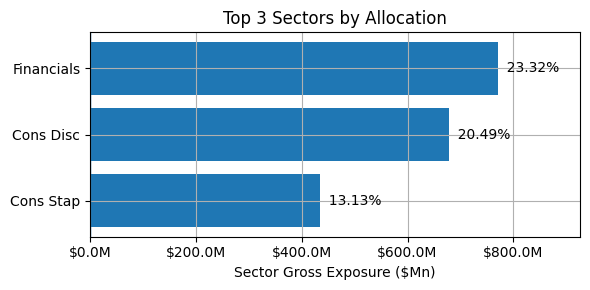

In [878]:
sector_allocation, sector_exposures = vhf.calc_sector_allocations(concise_positions)
vhf.plot_top_longs(sector_allocation.head(3), 'gross_exposure_usd','sector_weight', title = 'Top 3 Sectors by Allocation', xlabel='Sector Gross Exposure', color='tab:blue', figsize=(6,3))
plt.show();

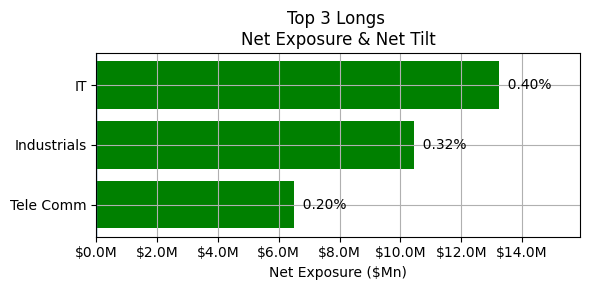

In [879]:

top_sector_longs = sector_exposures.sort_values('net_exposure_usd', ascending=False).head(3)
top_sector_shorts = sector_exposures.sort_values('net_exposure_usd').head(3)

vhf.plot_top_longs(
    top_sector_longs,
    value_col="net_exposure_usd",
    tilt_col="net_tilt_pct",
    unit="M",          
    tilt_is_pct=True,
    figsize=(6,3))

plt.show();

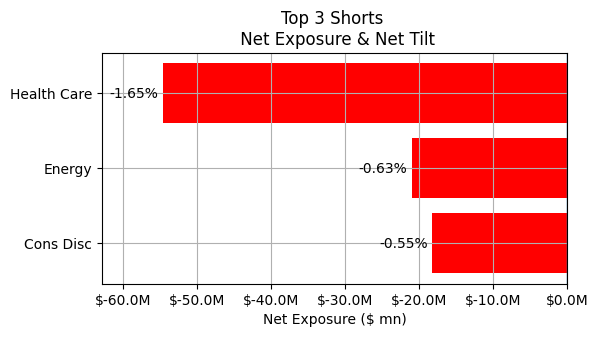

In [880]:

vhf.plot_top_shorts(top_sector_shorts, value_col="net_exposure_usd", tilt_col="net_tilt_pct", figsize=(6,3))
 
plt.show();


#### Key Country Positions and Exposures


USA, HKG and GBR have the largest allocations, with USA and HKG having gross market values of 9.43% and 9.42% of the entire portfolio ($312m and $311m respectively).

Biggest long positions by country (defined as net exposure ratio as percentage of entire portfolio's gross market value (GMV)) are FIN, GBR, and DEU - with FIN having the largest long exposure of 1.2% ($39m). Biggest short positions include France, Brazil, and Japan with the largest position of almost -2% net exposure ratio (-$65m).

In [881]:
country_tilt_pct    = vhf.build_country_tilt(concise_positions)[0]
country_allocations = vhf.build_country_allocation_summary(concise_positions)[0]
# Get the top 3 long and short countries by country tilt %
top_country_longs   = country_tilt_pct.sort_values(by='country_tilt_pct', ascending=False).head(3)
top_country_shorts  = country_tilt_pct.sort_values(by='country_tilt_pct').head(3)


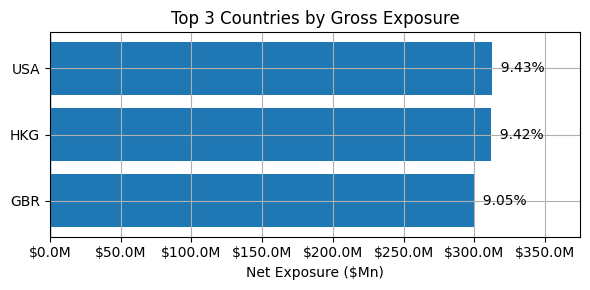

In [882]:

vhf.plot_top_longs(country_allocations.sort_values(by='gross_country_allocation_pct',ascending=False).head(3),
                   'gross_exposure_usd', title="Top 3 Countries by Gross Exposure", tilt_col = "gross_country_allocation_pct",
                   color='tab:blue')
plt.show();

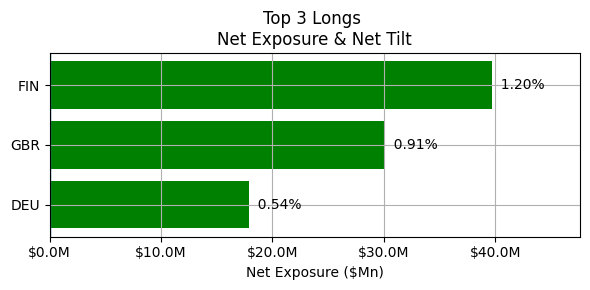

In [883]:

vhf.plot_top_longs(top_country_longs,
                   "net_exposure_usd",
                   "country_tilt_pct",
                   figsize=(6,3))
plt.show();

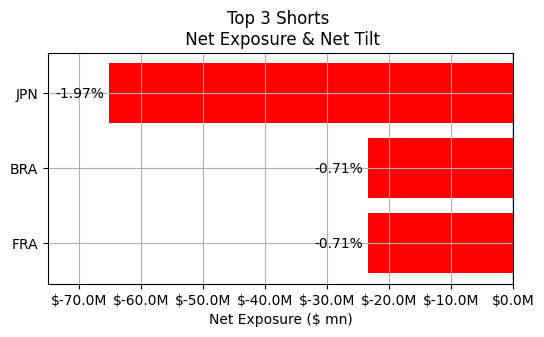

In [884]:

vhf.plot_top_shorts(top_country_shorts,
                    "net_exposure_usd",
                    "country_tilt_pct",
                    figsize=(6,3))

plt.show();

#### Key Beta-Adjusted Market Factor Exposures

The portfolio is net short, primarily driven from the top 3 short positions in Health Care, Energy, and Consumer Discretionary. Health Care is by far the largest beta-weighted tilt of -1.9% of the portfolio's gross beta-weighted exposure ($77.7m), with the Energy sector following at -1% ($40m). The portfolio is titled most net long on beta-weighted exposure in Industrials, Information Technology and Consumer Staples. The position with the largest net long market factor tilt is Industrials with 0.64% ($26.1m) - notably smaller than even the 3rd largest short position (Consumer Discretionary)


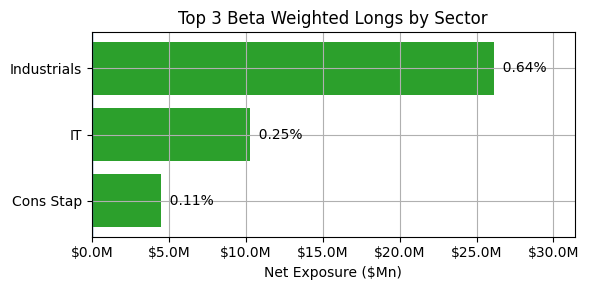

In [885]:
mkt_exposure_by_sector = vhf.calc_residual_mkt_exposure_by_sector(concise_positions)

top_beta_weighted_longs = mkt_exposure_by_sector.head(3)
top_beta_weighted_shorts = mkt_exposure_by_sector.tail(3)
vhf.plot_top_longs(top_beta_weighted_longs,
                   "beta_weighted_exposure_usd",
                   "beta_tilt_pct",
                   title="Top 3 Beta Weighted Longs by Sector",
                   color='tab:green')
plt.show();

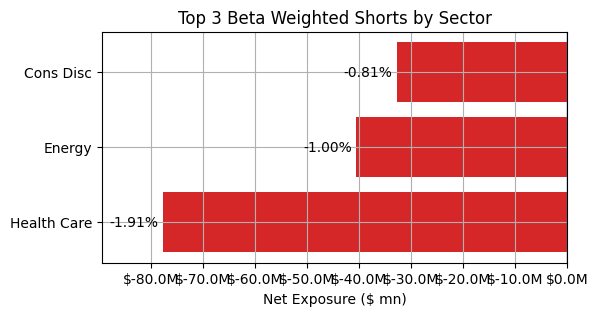

In [886]:

vhf.plot_top_shorts(top_beta_weighted_shorts,
                    "beta_weighted_exposure_usd",
                    "beta_tilt_pct",
                    title="Top 3 Beta Weighted Shorts by Sector",
                    color='tab:red',
                    figsize = (6, 3))
plt.show();

#### Key Market Risk Exposures by Country

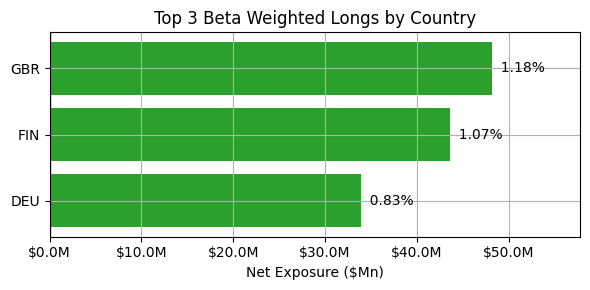

In [887]:
mkt_exposure_by_country = vhf.calc_country_tilt(concise_positions)[1]
mkt_exposure_by_country.sort_values(by='country_beta_tilt_pct', ascending=False, inplace=True)

vhf.plot_top_longs(mkt_exposure_by_country.head(3), 'beta_weighted_exposure_usd', 'country_beta_tilt_pct',
                   title='Top 3 Beta Weighted Longs by Country', color='tab:green', figsize=(6,3))

plt.show();

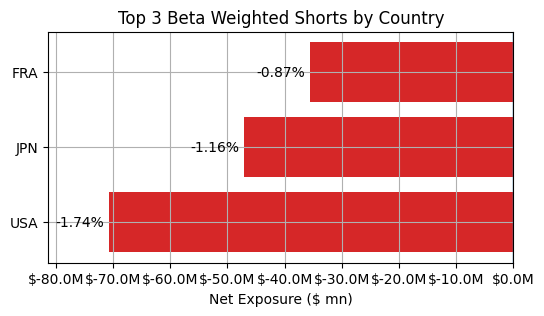

In [888]:
vhf.plot_top_shorts(mkt_exposure_by_country.tail(3), 'beta_weighted_exposure_usd', 'country_beta_tilt_pct',
                   title='Top 3 Beta Weighted Shorts by Country', color='tab:red', figsize=(6,3))


plt.show();

#### Key Sector/Country Combinations

At the country and sector level, we have a large short position in Japanese health care equities - with a net short position amounting to -1.4% of the entire portfolio (-$47.5m) and a group bias of -93.7% indicating both a large and concentrated position. We have a large and concentrated position in the Finnish Consumer Staples market with a long directional exposure (tilt) of 1.1% ($35.6m) of the portfolio. Our 3rd most concentrated position is a long position in Finnish Financials with 0.82% tilt ($27.4m), indicating potential country-specific risk.

In total, we have 8 highly concentrated and large positions at the country-sector level, primarily made up of a combination of Finnish, Spanish, Consumer Staples and Health Care exposures. The top 3 positions on the long and short side are highlighted below

In [889]:
concentrated_bets_c_s, most_concentrated_longs_c_s, most_concentrated_shorts_c_s = vhf.get_concentrated_bets(concise_positions, ['country', 'sector'], 0.5, 50)

print('\n Net Exposure and Gross Exposure are in $Mn\n Tilt and Bias are in %')
display(most_concentrated_longs_c_s[['net_exposure_usd', 'gross_exposure_usd', 'tilt', 'bias']].round(2))

print('\n Net Exposure and Gross Exposure are in $Mn\n Tilt and Bias are in %')
display(most_concentrated_shorts_c_s[['net_exposure_usd', 'gross_exposure_usd', 'tilt', 'bias']].round(2))


 Net Exposure and Gross Exposure are in $Mn
 Tilt and Bias are in %


,,net_exposure_usd,gross_exposure_usd,tilt,bias
sector,country,,,,
Consumer Staples,FIN,35.59,39.03,1.08,91.19
Financials,FIN,27.38,36.19,0.83,75.68
Health Care,ESP,24.56,24.84,0.74,98.88



 Net Exposure and Gross Exposure are in $Mn
 Tilt and Bias are in %


,,net_exposure_usd,gross_exposure_usd,tilt,bias
sector,country,,,,
Health Care,JPN,-47.52,50.71,-1.44,-93.72
Information Technology,USA,-18.70,31.51,-0.56,-59.33
Consumer Discretionary,ESP,-17.28,29.93,-0.52,-57.73


## Exposures 

#### Sector Exposures Summary

Gross book is $3.31bn and diversified, but concentrated in a few sectors. We have modest active tilts in certain sectors, with shorts outweighing longs but the book is largely sector neutral outside our top sector longs and shorts. 

**Gross book:** \$3.31bn:
  - Financials ~23%
  - Consumer Discretionary ~21%
  - Consumer Staples ~13%
  - Industrials ~11%
  - Health Care ~10%
  - IT ~9%
  - Energy ~6%
  - Utilities / Materials / Telecom: low single digits

 **Net tilts vs GMV:**
Small and broadly sector-neutral overall.
  - **Largest underweights (as % of GMV):** Health Care ≈ −1.7%, Energy ≈ −0.6%
  - **Largest overweights (as % of GMV):** IT ≈ 0.4%, Industrials ≈ 0.3%

/var/folders/2_/q3fhp8js4zgd2w2m2cb4y8rh0000gn/T/ipykernel_82072/3952555748.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(shorten_labels(net_exposures.index), rotation=45, ha='right')
/var/folders/2_/q3fhp8js4zgd2w2m2cb4y8rh0000gn/T/ipykernel_82072/3952555748.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(shorten_labels(sector_exposures.index))


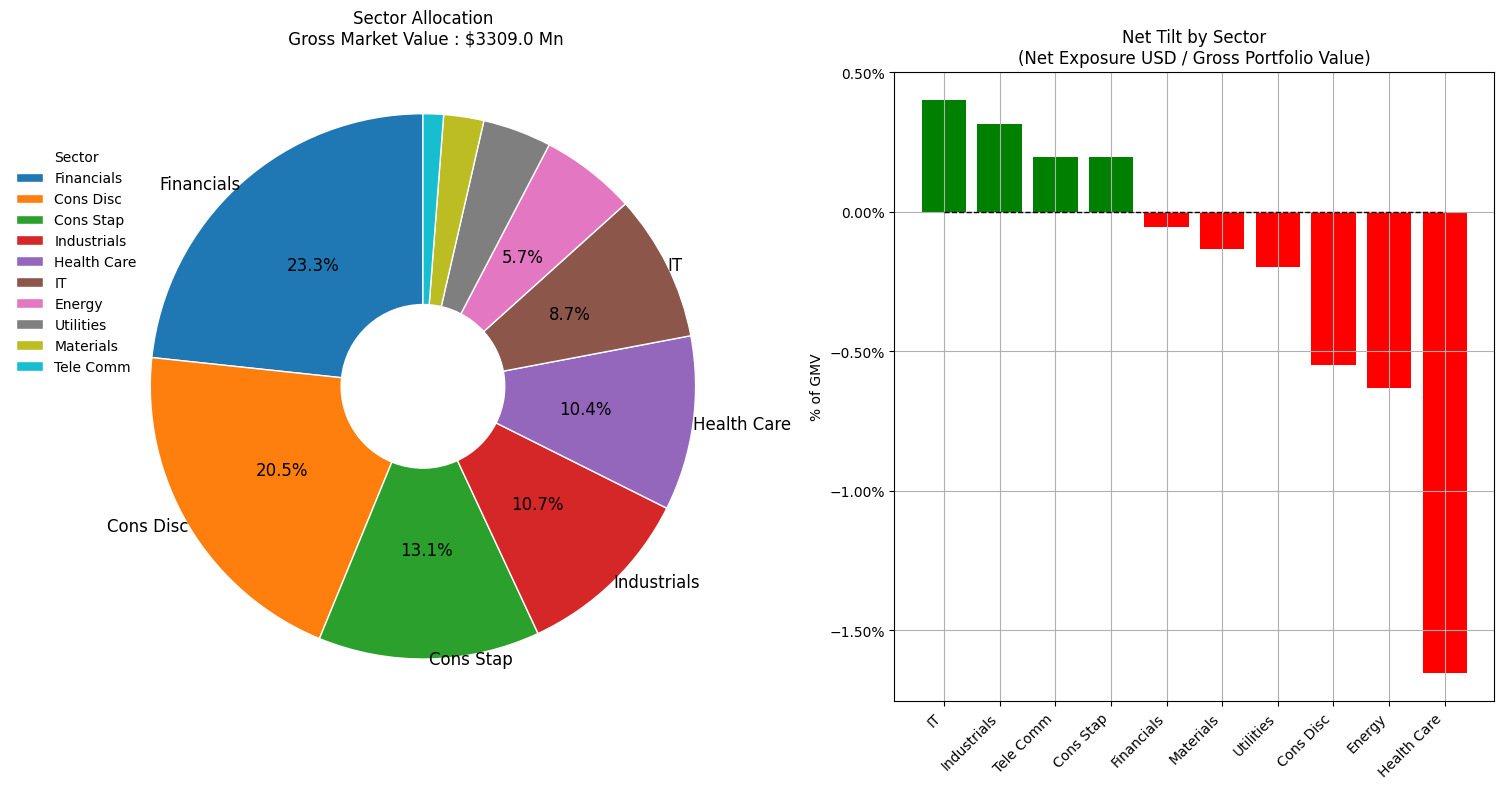

In [890]:
sector_allocation, sector_exposures = vhf.calc_sector_allocations(concise_positions)
net_exposures, l_s_per_sector = vhf.calc_long_short_exposure_per_sector(concise_positions)


fig, axs = plt.subplots(1,2,figsize=(15,8))



# Plot net tilts by sector
axs[1].grid()
axs[1].set_xticklabels(shorten_labels(net_exposures.index), rotation=45, ha='right')

axs[1].bar(sector_exposures.index,
           sector_exposures['net_tilt_pct'],
           color=['green' if x > 0 else 'red' for x in net_exposures]
)
axs[1].hlines(0, lw=1, color='black', xmin=0, xmax=9, ls = '--')
axs[1].yaxis.set_major_formatter(PercentFormatter(100))
axs[1].set_ylabel('% of GMV')
axs[1].set_xticklabels(shorten_labels(sector_exposures.index))
axs[1].set_title('Net Tilt by Sector\n(Net Exposure USD / Gross Portfolio Value)')

sector_exposures['net_tilt_pct'].sum()

def autopct_filter(p):
    return f'{p:.1f}%' if p >= 5 else ''

gross_exposure = concise_positions[['gross_exposure_usd']].sum()
gross_exposure_mn = np.round(gross_exposure.iloc[0] / 1e6)

# Show how large we are in every sector
wedges, texts, autotexts = axs[0].pie(
    sector_allocation['sector_weight'],
    labels=shorten_labels(sector_allocation.index)[:6] + [None] * (len(shorten_labels(sector_allocation.index)) - 6),
    autopct=autopct_filter,
    wedgeprops={'edgecolor': 'white', 'width' : 0.7},
    startangle=90,
    textprops={'fontsize': 12},
    labeldistance=1
)
axs[0].legend(
    wedges, shorten_labels(sector_allocation.index), title='Sector',
    loc='lower left', frameon=False, bbox_to_anchor=(-0.2, 0.5)
)
axs[0].set_title(f'Sector Allocation\n Gross Market Value : ${gross_exposure_mn} Mn', pad=20)
axs[0].axis('equal') 

plt.tight_layout()
plt.show()




In [891]:
display(sector_exposures.round(2))


,net_exposure_usd,gross_exposure_usd,net_tilt_pct
sector,,,
Information Technology,13256454.22,2.879550e+08,0.40
Industrials,10444643.31,3.536770e+08,0.32
Telecommunication Services,6502652.53,4.013743e+07,0.20
Consumer Staples,6499566.27,4.346532e+08,0.20
Financials,-1802248.72,7.715557e+08,-0.05
Materials,-4399032.81,7.867577e+07,-0.13
Utilities,-6486549.93,1.348858e+08,-0.20
Consumer Discretionary,-18209101.43,6.779567e+08,-0.55
Energy,-20935901.16,1.872072e+08,-0.63


In [892]:

print('Everything is in $Mn except for tilts and pct')
l_s_by_sector                        = vhf.calc_long_short_exposure_per_sector(concise_positions)[1]
sector_allocations, sector_exposures = vhf.calc_sector_allocations(concise_positions)
sector_breakdown                     = vhf.get_sector_metrics(l_s_by_sector, sector_exposures)
sector_breakdown.loc[:, ['LONG', 'SHORT', 'GROSS','net_exposure_usd', 'gross_exposure_usd']] = sector_breakdown.loc[:, ['LONG', 'SHORT', 'GROSS','net_exposure_usd', 'gross_exposure_usd']]/1e6
sector_breakdown.rename(columns={'directional_sector_tilt_pct' : 'sector_bias_pct'}, inplace=True)
display(sector_breakdown.round(2))

Everything is in $Mn except for tilts and pct


,LONG,SHORT,GROSS,% Long,% Short,sector_bias_pct,net_exposure_usd,gross_exposure_usd,net_tilt_pct
sector,,,,,,,,,
Consumer Discretionary,329.87,348.08,677.96,48.66,51.34,-2.69,-18.21,677.96,-0.55
Consumer Staples,220.58,214.08,434.65,50.75,49.25,1.50,6.50,434.65,0.20
Energy,83.14,104.07,187.21,44.41,55.59,-11.18,-20.94,187.21,-0.63
Financials,384.88,386.68,771.56,49.88,50.12,-0.23,-1.80,771.56,-0.05
Health Care,143.94,198.58,342.52,42.02,57.98,-15.95,-54.65,342.52,-1.65
Industrials,182.06,171.62,353.68,51.48,48.52,2.95,10.44,353.68,0.32
Information Technology,150.61,137.35,287.95,52.30,47.70,4.60,13.26,287.95,0.40
Materials,37.14,41.54,78.68,47.20,52.80,-5.59,-4.40,78.68,-0.13
Telecommunication Services,23.32,16.82,40.14,58.10,41.90,16.20,6.50,40.14,0.20


#### Market Factor Exposures Summary





**Summary**

On a beta-weighted basis, the book’s gross market load sits mainly in Financials (~23%), Consumer Discretionary (~20%), and Consumer Staples (~14%). The largest net beta tilts are short Health Care (~−1.9% of portfolio beta-gross) and short Energy (~−1.0%), partly offset by long Industrials (~+0.6%) and long IT (~+0.25%), with smaller longs in Staples/Financials and a short in Cons Disc (~−0.8%). There are

This leads to a total net beta tilt of **-2.77% ($112.5m)** (out of $4,066m of gross beta-weighted market exposure). The book is tilted pro-cyclical/growth (Industrials, IT) and underweight defensives and commodities (Health Care, Energy), implying a potential loading on the long high beta/risk-on and short defensive.

**Key Positions Net Tilts**
- Largest beta-adjusted tilts of portfolio beta-gross:
    - Industrials (~+0.64%)
    - Health Care (~−1.9%)
    - Energy (~−1.0%)
    - Cons Disc (~−0.8%)


/var/folders/2_/q3fhp8js4zgd2w2m2cb4y8rh0000gn/T/ipykernel_82072/1187251672.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(shorten_labels(beta_weighted_sector_exposures.index), rotation=45, ha='right')
/var/folders/2_/q3fhp8js4zgd2w2m2cb4y8rh0000gn/T/ipykernel_82072/1187251672.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(shorten_labels(beta_weighted_sector_exposures.index))


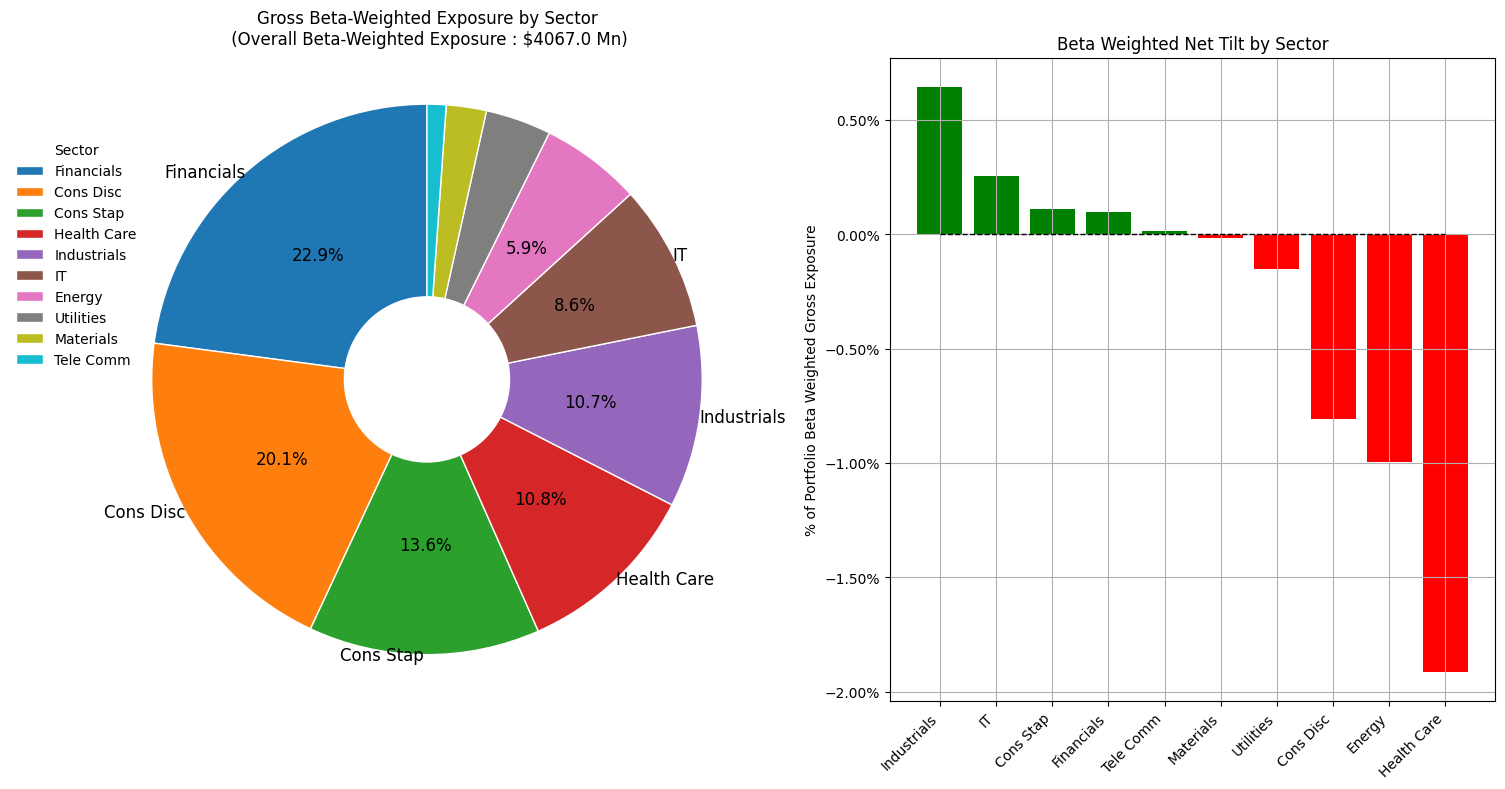

In [893]:

beta_weighted_sector_allocations, beta_weighted_sector_exposures = vhf.calc_beta_weighted_sector_allocations(concise_positions)


fig, axs = plt.subplots(1,2,figsize=(15,8))
# Plot net tilts by sector
axs[1].grid()
axs[1].set_xticklabels(shorten_labels(beta_weighted_sector_exposures.index), rotation=45, ha='right')

axs[1].bar(beta_weighted_sector_exposures.index,
           beta_weighted_sector_exposures['net_tilt_pct'],
           color=['green' if x > 0 else 'red' for x in beta_weighted_sector_exposures['beta_weighted_exposure_usd']]
)
axs[1].hlines(0, lw=1, color='black', xmin=0, xmax=9, ls = '--')
axs[1].yaxis.set_major_formatter(PercentFormatter(100))
axs[1].set_ylabel('% of Portfolio Beta Weighted Gross Exposure')
axs[1].set_xticklabels(shorten_labels(beta_weighted_sector_exposures.index))
axs[1].set_title('Beta Weighted Net Tilt by Sector')


def autopct_filter(p):
    return f'{p:.1f}%' if p >= 5 else ''


# Show how large we are in every sector
wedges, texts, autotexts = axs[0].pie(
    beta_weighted_sector_allocations['sector_weight'],
    labels=shorten_labels(beta_weighted_sector_allocations.index)[:6] + [None] * (len(shorten_labels(beta_weighted_sector_allocations.index)) - 6),
    autopct=autopct_filter,
    wedgeprops={'edgecolor': 'white', 'width' : 0.7},
    startangle=90,
    textprops={'fontsize': 12},
    labeldistance=1
)
axs[0].legend(
    wedges, shorten_labels(beta_weighted_sector_allocations.index), title='Sector',
    loc='lower left', frameon=False, bbox_to_anchor=(-0.2, 0.5)
)

gross_beta_exposure = concise_positions[['beta_weighted_exposure_usd']].abs().sum()
gross_beta_exposure_mn = np.round(gross_beta_exposure / 1e6)
axs[0].set_title(f'Gross Beta-Weighted Exposure by Sector\n (Overall Beta-Weighted Exposure : ${gross_beta_exposure_mn.iloc[0]} Mn)', pad=10)
axs[0].axis('equal') 
plt.tight_layout()
plt.show()




In [894]:
net_beta_weighted_exposures, beta_l_s_per_sector = vhf.calc_l_s_beta_weighted_sector_exposures(concise_positions)
beta_sector_bias = beta_l_s_per_sector.loc['beta_sector_bias'].sort_values(ascending=False).droplevel(0)
beta_l_s_per_sector.loc[['LONG', 'SHORT', 'GROSS']]  = beta_l_s_per_sector.loc[['LONG', 'SHORT', 'GROSS']] / 1e6
display(beta_l_s_per_sector.round(2))



beta_weighted_exposure_usd                           \
sector                Consumer Discretionary Consumer Staples  Energy   
side                                                                    
LONG                                  393.33           278.44   99.96   
SHORT                                 426.11           273.94  140.47   
GROSS                                 819.44           552.38  240.43   
% Long                                 48.00            50.41   41.57   
% Short                                52.00            49.59   58.43   
beta_sector_bias                       -4.00             0.82  -16.85   
beta_net_tilt_pct                      -0.81             0.11   -1.00   

                                                                             \
sector            Financials Health Care Industrials Information Technology   
side                                                                          
LONG                  467.52      181.55      230.27                 180.05   
SHORT                 463.67      259.34      204.13                 169.78   
GROSS                 931.19      440.88      434.40                 349.83   
% Long                 50.21       41.18       53.01                  51.47   
% Short                49.79       58.82       46.99                  48.53   
beta_sector_bias        0.41      -17.64        6.02                   2.93   
beta_net_tilt_pct       0.09       -1.91        0.64                   0.25   

                                                                  
sector            Materials Telecommunication Services Utilities  
side                                                              
LONG                  47.56                      23.03     75.40  
SHORT                 48.22                      22.41     81.59  
GROSS                 95.78                      45.45    156.99  
% Long                49.65                      50.68     48.03  
% Short               50.35                      49.32     51.97  
beta_sector_bias      -0.70                       1.36     -3.94  
beta_net_tilt_pct     -0.02                       0.02     -0.15

#### Country Exposures Summary

The book’s gross exposure is spread across USA $312.1m (9.43% GMV), HKG $311.8m (9.42%), GBR $299.6m (9.05%), DEU $277.7m (8.39%), and JPN $211.5m (6.39%)—these top five sum to ~42.7% of GMV. 

On a beta-weighted basis the ordering is similar: HKG 9.89% of β-GMV ($402.1m), USA 9.58% ($389.6m), GBR 8.87% ($360.9m), DEU 8.16% ($331.8m), JPN 6.15% ($250.3m)

**Risk Exposures**

The porfolio is directionally short JPY and long FIN/GBR/DEU. The portfolio is also positively beta-tilted to FIN/GBR (1.07% and 1.18% of portfolio beta-GMV).

The largest negative beta tilt is USA at -1.74% of portfolio beta-GMV, driven by high beta USA shorts (where USA shorts have a value-weighted average beta of 1.37 while USA longs have a value-weighted average beta of 1.08).

Given the portfolio is already tilted negative beta of 0.03, reducing positioning in high beta shorts in US or large negative tilts in JPN can enable us to return to a beta-neutral portfolio.

In [895]:
country_tilt_pct, country_beta_weighted_tilt_pct, country_allocations, country_beta_exposure, l_s_per_country, beta_w_l_s_per_country = vhf.calc_country_tilt(concise_positions)

country_allocations = country_allocations.sort_values('gross_exposure_usd', ascending=False)
country_allocations['gross_exposure_usd'] = country_allocations['gross_exposure_usd'] / 1e6

country_beta_exposure['beta_weighted_exposure_usd'] = country_beta_exposure['beta_weighted_exposure_usd'] / 1e6
country_beta_exposure = country_beta_exposure.loc[country_allocations.index]

country_tilt_pct                       = country_tilt_pct.sort_values('country_tilt_pct', ascending=False)
country_tilt_pct['gross_exposure_usd'] = country_tilt_pct['gross_exposure_usd'] / 1e6

country_beta_weighted_tilt_pct['beta_weighted_exposure_usd'] = country_beta_weighted_tilt_pct['beta_weighted_exposure_usd'] / 1e6
country_beta_weighted_tilt_pct = country_beta_weighted_tilt_pct.loc[country_tilt_pct.index]



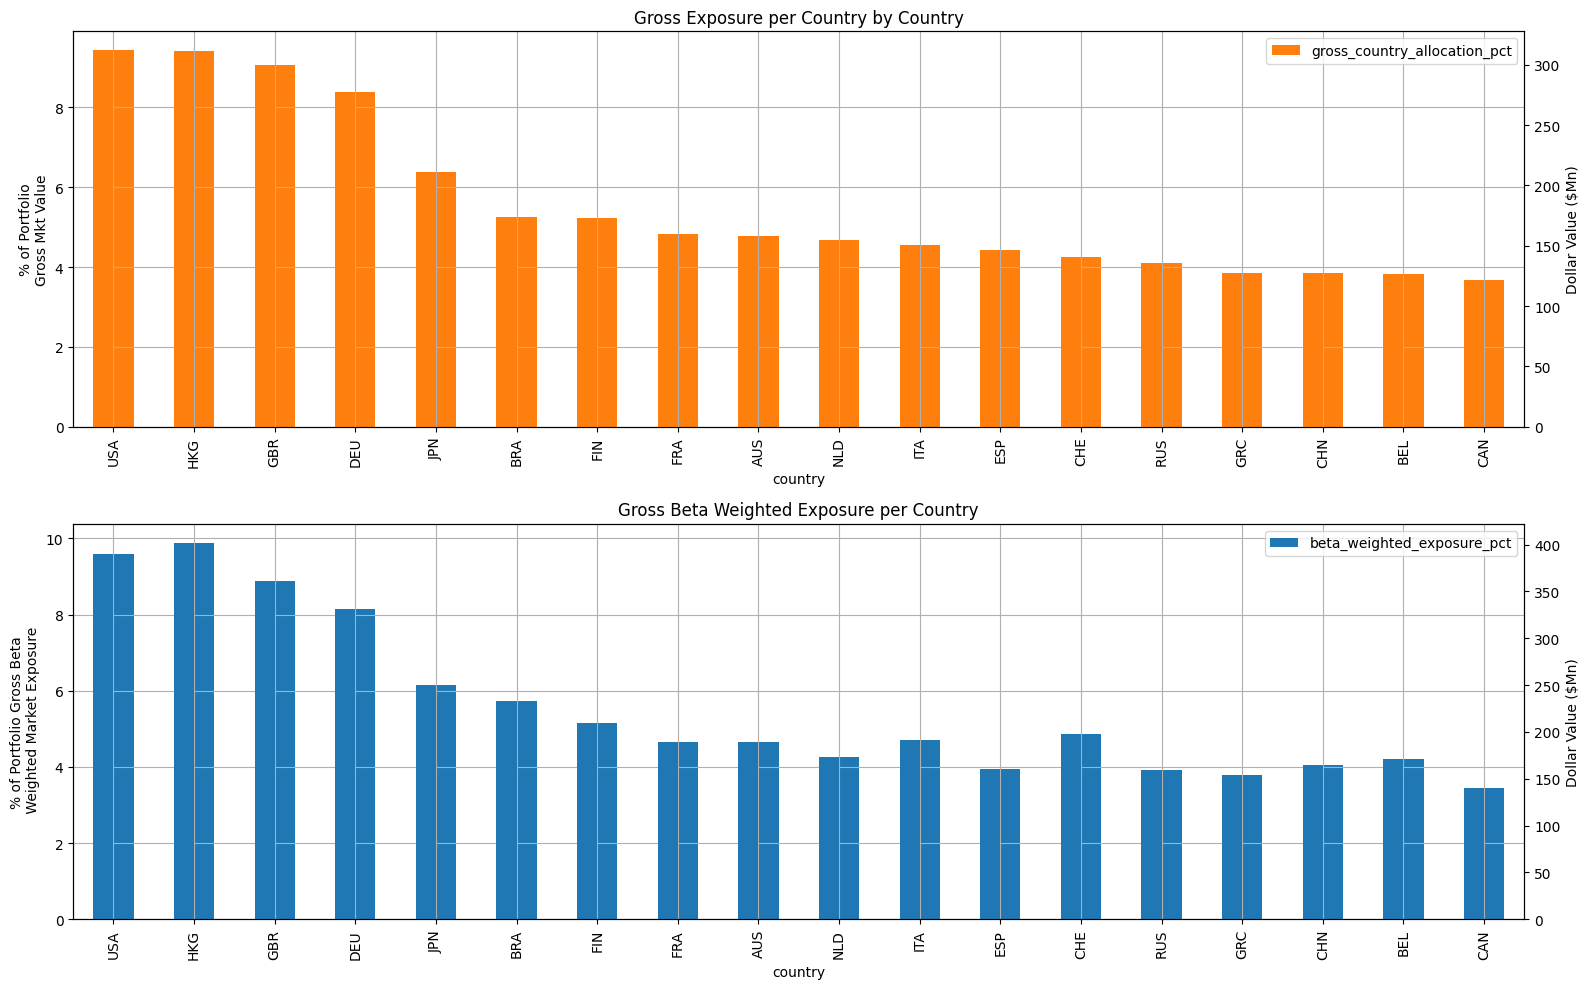

In [896]:
fig, axs = plt.subplots(2, 1, figsize = (16, 10))


ax1 = country_allocations.plot(
    kind = 'bar',
    secondary_y='gross_exposure_usd',
    color=('tab:orange', 'tab:orange'),
    legend=False,
    ax = axs[0],
)

ax1.set_title('Gross Exposure per Country by Country')
ax1.set_ylabel('% of Portfolio\nGross Mkt Value')
ax1.right_ax.set_ylabel('Dollar Value ($Mn)')

ax2 = country_beta_exposure.plot(
    kind = 'bar',
    secondary_y='beta_weighted_exposure_usd',
    color=('tab:blue', 'tab:blue'),
    legend=False,
    ax = axs[1]
)


ax2.set_title('Gross Beta Weighted Exposure per Country')
ax2.set_ylabel('% of Portfolio Gross Beta\n Weighted Market Exposure')
ax2.right_ax.set_ylabel('Dollar Value ($Mn)')

ax1.grid()
ax2.grid()  
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show();

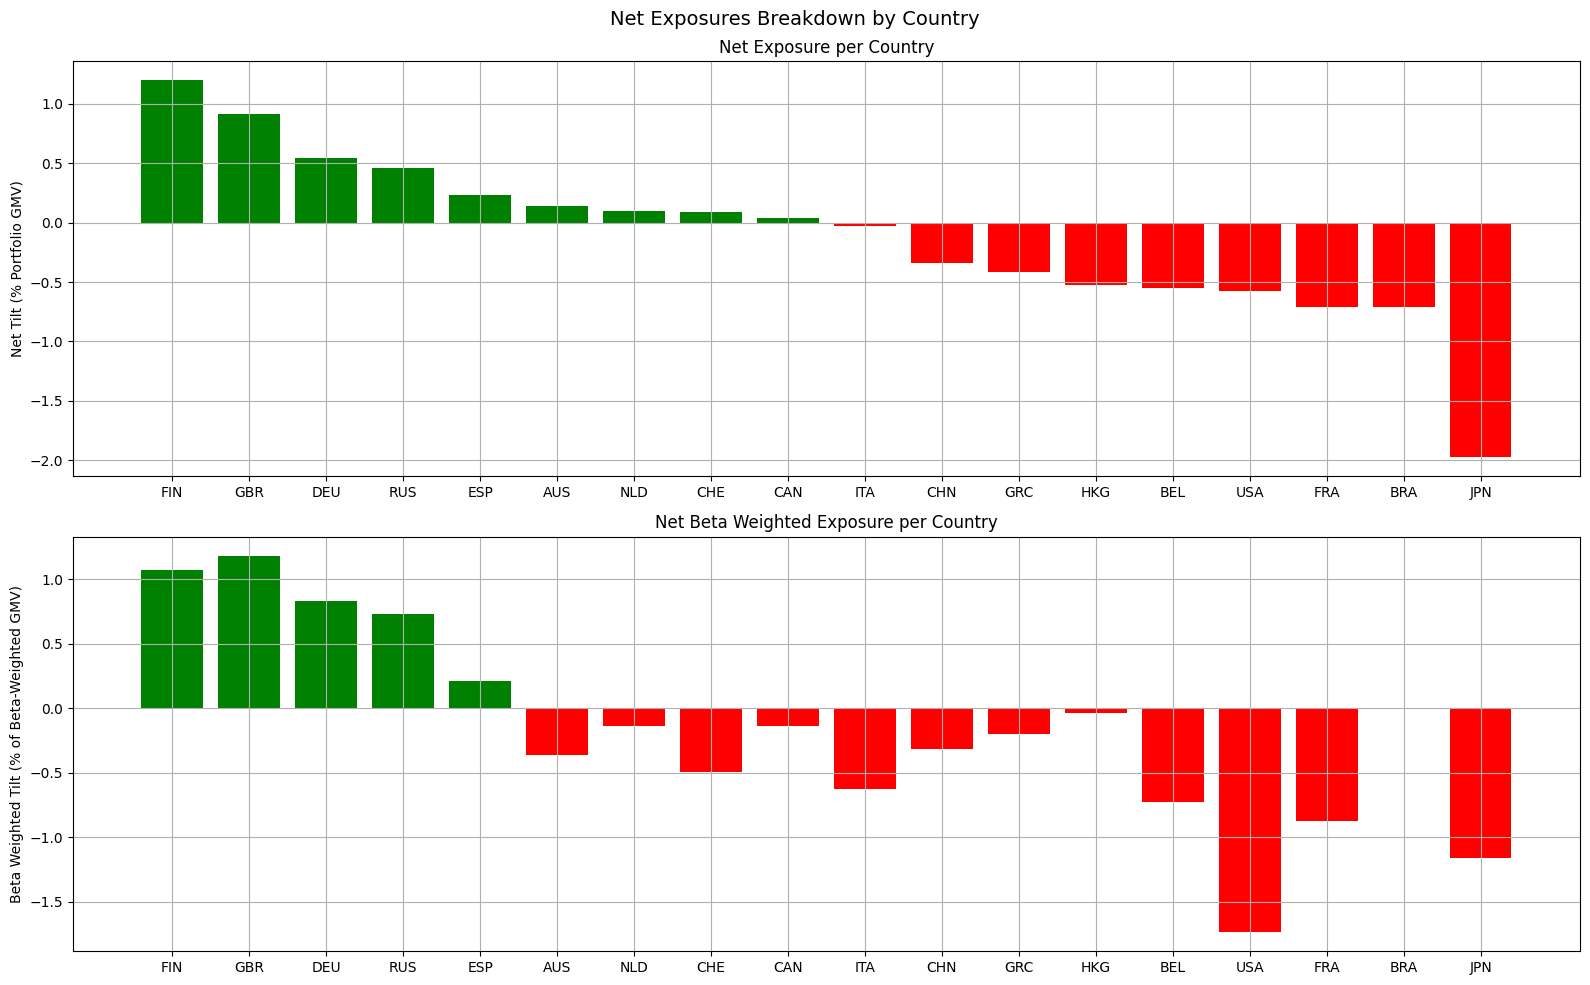

In [897]:
fig, axs = plt.subplots(2, 1, figsize = (16, 10))



# Plot 1) net exposure
axs[0].set_title('Net Exposure per Country')
axs[0].set_ylabel('Net Tilt (% Portfolio GMV)')
axs[0].bar(
    country_tilt_pct.index,
    country_tilt_pct['country_tilt_pct'],
    label = '$Mn Net Exposure',
    color=['green' if x > 0 else 'red' for x in country_tilt_pct['country_tilt_pct']],

)

# Plot 2) Plot beta weighted market exposure 
axs[1].set_title('Net Beta Weighted Exposure per Country')
axs[1].set_ylabel('Beta Weighted Tilt (% of Beta-Weighted GMV)')

axs[1].bar(
    country_beta_weighted_tilt_pct.index, 
    country_beta_weighted_tilt_pct['country_beta_tilt_pct'],    
    color=['green' if x > 0 else 'red' for x in country_beta_weighted_tilt_pct['country_beta_tilt_pct']],
    label='$Mn Beta Weighted Net Tilt'
)


axs[1].grid()
axs[0].grid()  


plt.suptitle('Net Exposures Breakdown by Country', fontsize=14)
plt.tight_layout()
plt.show();

#### FX Exposures Summary

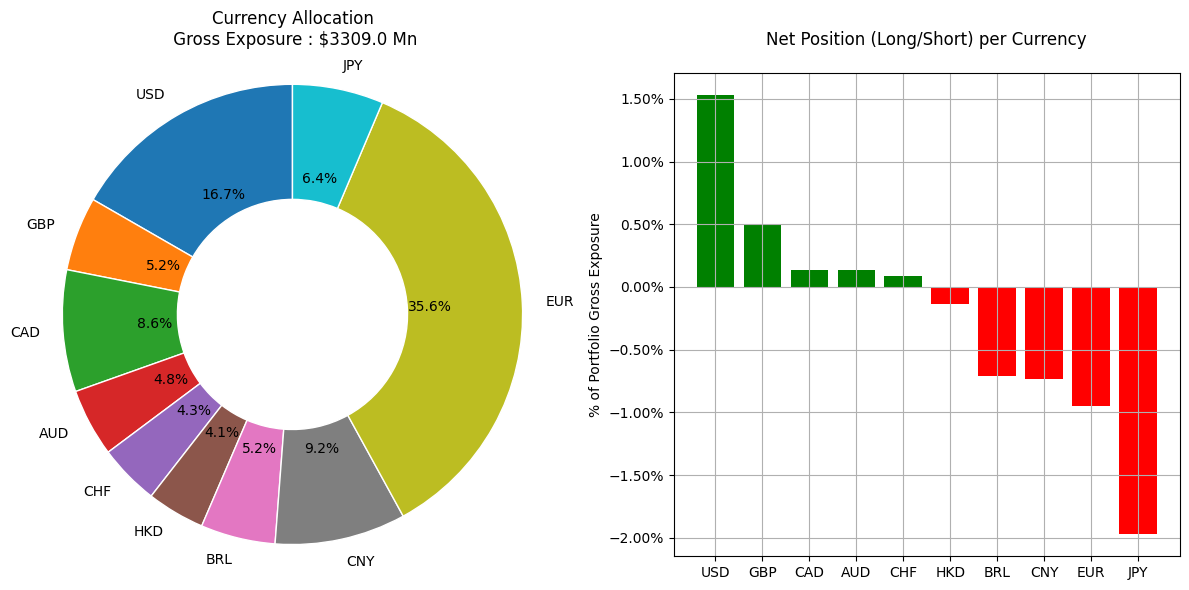

In [898]:

currency_positions = vhf.calc_currency_positions(concise_positions)
fig, axs = plt.subplots(1,2,figsize=(12,6))
currency_positions = vhf.calc_currency_positions(concise_positions)
gross_exposure = concise_positions[['gross_exposure_usd']].sum()
gross_exposure_mn = np.round(gross_exposure.iloc[0] / 1e6)
# Show how large we are in every currency
axs[0].pie(
    currency_positions['gross_exposure_usd'],
    labels=currency_positions.index,
    autopct='%1.1f%%',
    wedgeprops={'edgecolor': 'white', 'width' : 0.5},
    startangle=90
)

axs[0].set_title(f'Currency Allocation\n Gross Exposure : ${gross_exposure_mn} Mn', pad=20)
axs[0].axis('equal') 


# For each currency how long/short we are as % of our gross exposure

axs[1].bar(
    currency_positions.index,
    currency_positions['net_tilt_pct'],
    color=['green' if x > 0 else 'red' for x in currency_positions['net_tilt_pct']]
)
axs[1].grid()
axs[1].set_title(f'Net Position (Long/Short) per Currency', pad=20)
axs[1].set_ylabel('% of Portfolio Gross Exposure')
axs[1].yaxis.set_major_formatter(PercentFormatter(100))

plt.tight_layout()
plt.show()

#### Industry / Sub Industry Breakdown & Summary

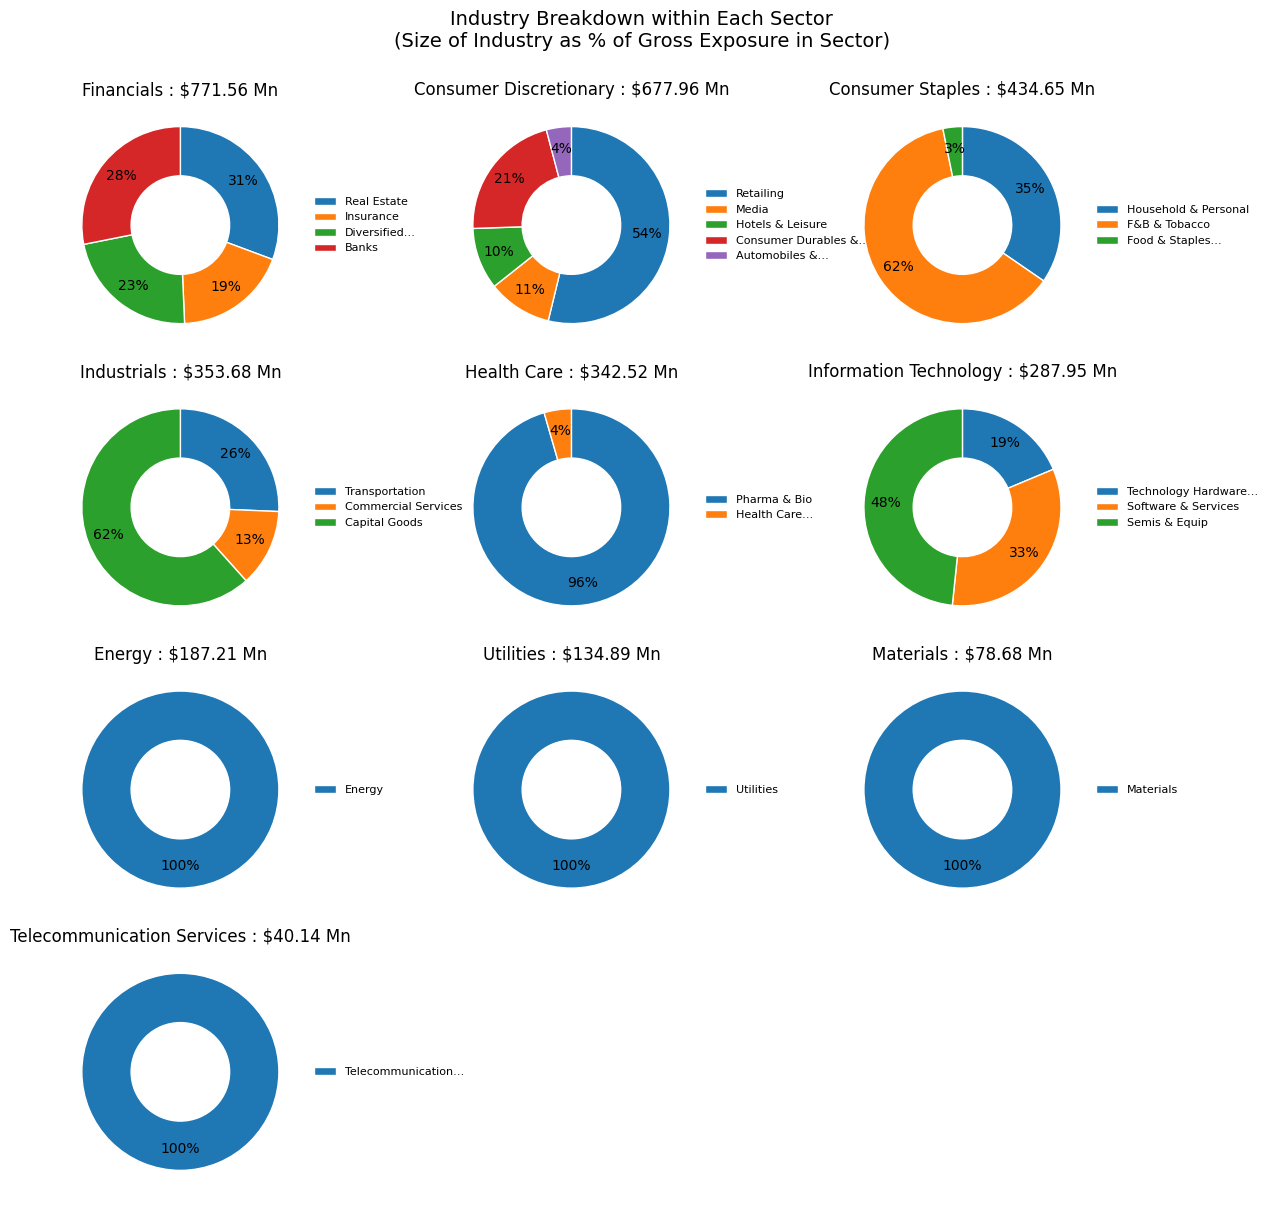

In [899]:
importlib.reload(vhf)
industry_breakdown = vhf.breakdown_by_industry(concise_positions, figsize=(12,12))
plt.suptitle('Industry Breakdown within Each Sector\n(Size of Industry as % of Gross Exposure in Sector)', fontsize=14, y = 1)
plt.tight_layout()
plt.show();


#### Sub Industry Concentration Summary

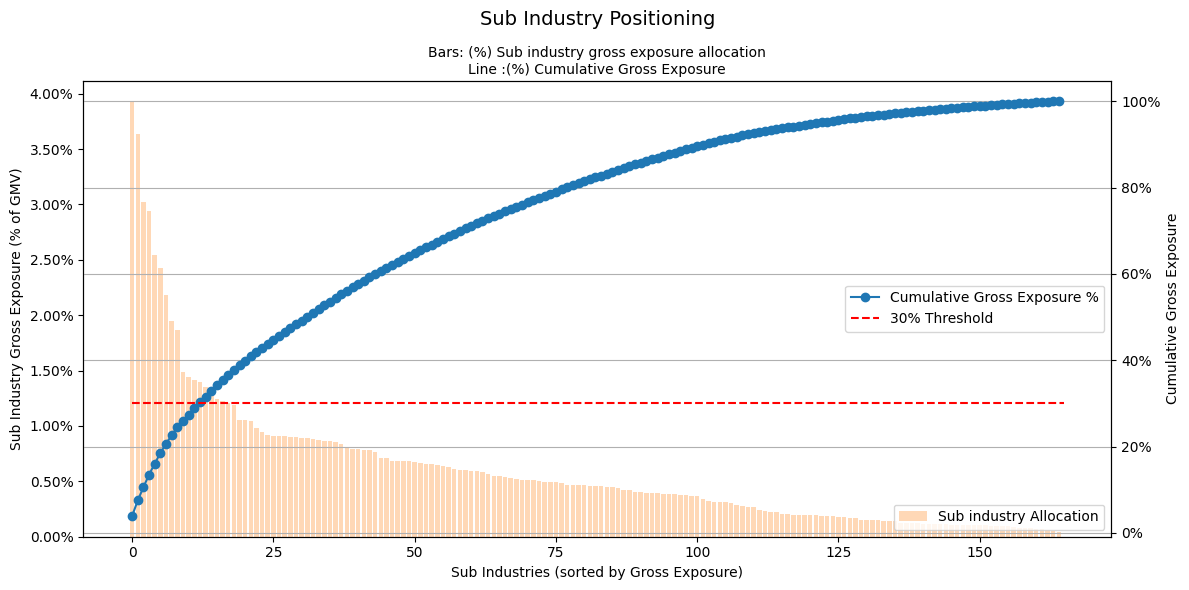

In [900]:

sub_ind_tilts       = vhf.get_sub_industry_tilts(concise_positions)
sub_ind_allocation  = vhf.get_sub_industry_allocation(concise_positions)

fig, axs = plt.subplots(1, 1, figsize=(12,6))

axs2 = axs.twinx()

# Plot cumulative gross exposure %
axs2.plot([i for i in range(len(sub_ind_allocation))],
         sub_ind_allocation['cumsum_GE_pct'],
         marker='o',
         label='Cumulative Gross Exposure %')
axs2.set_ylabel('Cumulative Gross Exposure')

# Plot gross exposure per sub industry as % of GMV
axs.bar([i for i in range(len(sub_ind_allocation))],
        sub_ind_allocation['gross_exposure_usd'] * 1e6 / gmv * 100,
        alpha = 0.3,
        color='tab:orange',
        label='Sub industry Allocation')
axs.set_ylabel('Sub Industry Gross Exposure (% of GMV)')

# Threshold of 30% cumulative gross exposure explained
plt.hlines(30, xmin=0, xmax=len(sub_ind_allocation), colors='red', linestyles='--', label='30% Threshold')

axs.set_title('Sub Industry Positioning',fontsize =14, pad = 40)
axs2.set_title('Bars: (%) Sub industry gross exposure allocation\nLine :(%) Cumulative Gross Exposure', fontsize = 10, pad = 5)

plt.legend()

axs.legend(loc='lower right')
axs2.legend(loc='center right')
axs2.yaxis.set_major_formatter(PercentFormatter(100))
axs.yaxis.set_major_formatter(PercentFormatter(100))


axs2.grid()
axs.set_xlabel('Sub Industries (sorted by Gross Exposure)')
plt.tight_layout()
plt.show();

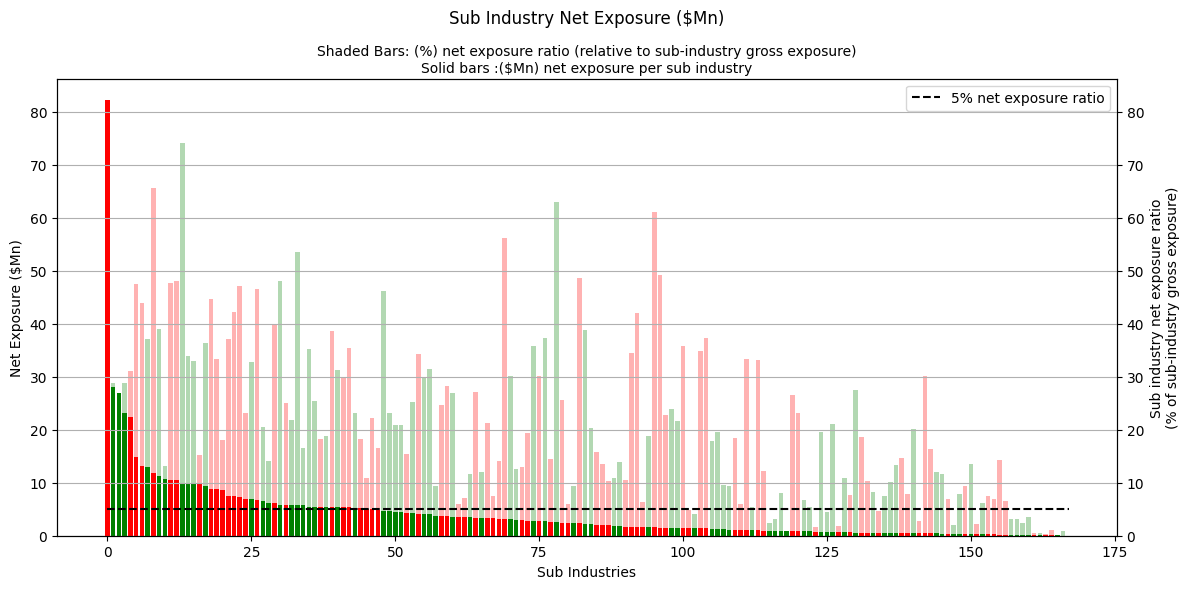

In [901]:
fig, axs = plt.subplots(1, 1, figsize=(12,6))
axs2 = axs.twinx()

sub_ind_breakdown   = vhf.get_sub_industry_breakdown(concise_positions)[0]

sub_ind_breakdown.sort_values('net_exposure_usd', ascending=False, inplace=True, key = lambda x : x.abs())
# Plot net exposure in $Mn per sub industry
axs.bar(
    [i for i in range(len(sub_ind_breakdown))],
    sub_ind_breakdown['net_exposure_usd'].abs(),
    color=['green' if x > 0 else 'red' for x in sub_ind_breakdown['net_exposure_usd']]
)

axs2.bar(
    [i for i in range(len(sub_ind_breakdown))],
    sub_ind_breakdown['net_exposure_usd'].abs() / sub_ind_breakdown['gross_exposure_usd'].abs() * 100,
    alpha=0.3,
    color=['green' if x > 0 else 'red' for x in sub_ind_breakdown['net_exposure_usd']]
)

axs2.hlines(5, xmin=0, xmax=len(sub_ind_breakdown), colors='black', linestyles='--', label='5% net exposure ratio')
axs2.legend()
axs.set_ylabel('Net Exposure ($Mn)')
axs2.set_ylabel('Sub industry net exposure ratio\n(% of sub-industry gross exposure)')
axs.set_xlabel('Sub Industries')
axs.set_title('Sub Industry Net Exposure ($Mn)', pad = 40)
axs2.set_title('Shaded Bars: (%) net exposure ratio (relative to sub-industry gross exposure)\nSolid bars :($Mn) net exposure per sub industry', fontsize = 10, pad = 5)
plt.tight_layout()
plt.grid()

#### Sub Industries with significant directional exposure and allocation


Identify the sub industries that we have concentrated positions in (where we have allocated at least 1% of our portfolio's gross market value) and a directional exposure (net exposure larger than 5%)

Within the sub industries per industry, we have notable exposures particularly in

1. Information Technology (Semiconductors; Semiconductor Equipment) :
        1. Semiconductors with a net long exposure of ~13% and allocation of ~2%
        2. Semiconductors with a net short position of ~ -3.5% and allocation of ~1.4%
    
2. Healthcare (Pharmaceuticals & Biotechnology):
        1. Life Sciences Tools & Services with a net short position of ~ -80% and allocation of ~ 2.5%
        2. Pharmacueticals with a net long exposure of ~28% and allocation of 2.4%

3. Financials (Banks & Diversified Financials):
        1. Regional banks with a net long exposure of ~28% and allocation of ~2%
        2. Diversified Banks with a net short exposure of ~ -3.5% and allocation of ~1.8%
        3. Thrifts & Mortgage Finance with a net exposure of -15% and allocation of ~ 1.6%
        4. Consumer Finance has a net long exposure of 14% and allocation of ~ 1.1%

4. Consumer Staples (Household & Personal Products; Food Beverage & Tobacco):
        1. Household Products with a net long exposure of ~22% and allocation of ~3%
        2. Meat Poultry & Fish with a net short exposure of ~ -7% and allocation of ~1.2%
        3. Brewers with a net short exposure of -18% and allocation of ~ 1.2%
        4. Distillers & Vintners with has a net short exposure of ~ -11% and allocation of ~ 1.2%

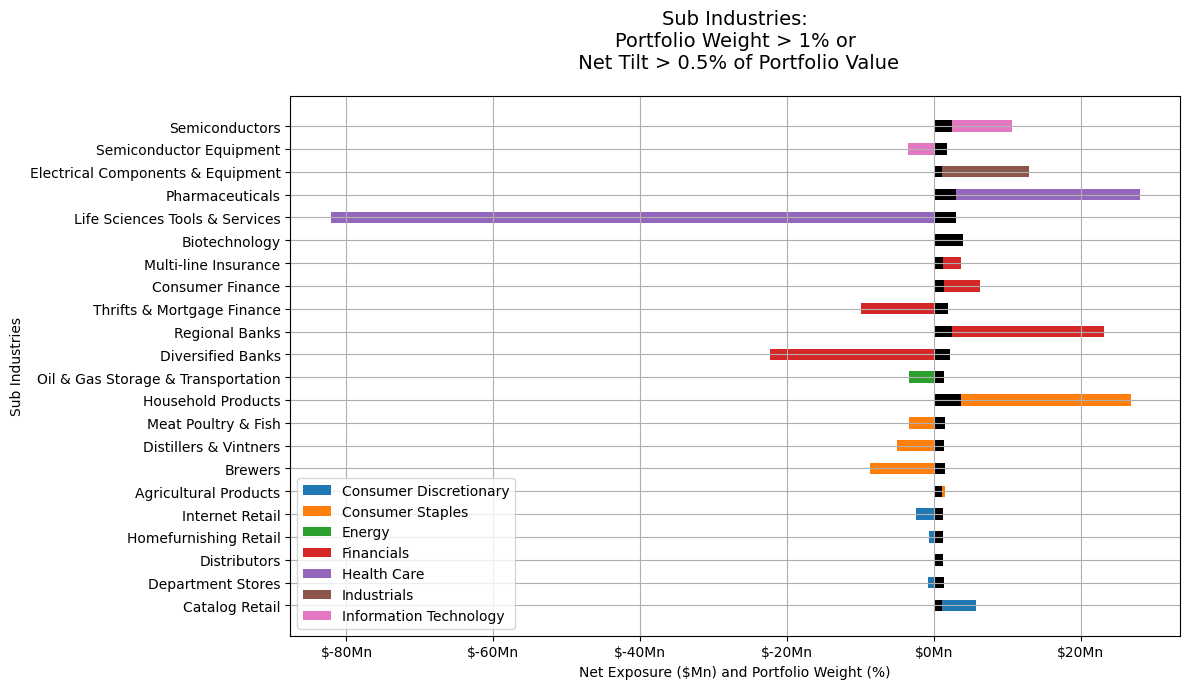

In [902]:
from matplotlib.ticker import FuncFormatter

sub_ind_allocation, sub_ind_allocation_beta  = vhf.get_sub_industry_breakdown(concise_positions)
notable_sub_ind = sub_ind_allocation[(sub_ind_allocation['net_tilt_pct'].abs() > 0.5) | (sub_ind_allocation['portfolio_weight'] > 1)].copy()
fig, axs = plt.subplots(1, figsize=(12,7))

for c, i in enumerate(notable_sub_ind.index.get_level_values(0).unique()):
    df = notable_sub_ind.loc[i]
    axs.barh(
        df.index.get_level_values(1),
        df['net_exposure_usd'],
        label=f'{i}',
        height = 0.5,
  )
    axs.barh(
        df.index.get_level_values(1),
        df['portfolio_weight'],
        height = 0.5,
        color='black')
    
plt.ylabel('Sub Industries')
axs.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:.0f}Mn'))
plt.xlabel('Net Exposure ($Mn) and Portfolio Weight (%)')
plt.title('Sub Industries:\nPortfolio Weight > 1% or\n Net Tilt > 0.5% of Portfolio Value', fontsize=14, pad=20)
plt.legend()
plt.grid()
plt.tight_layout()

#### Sectors x Country Exposure Summary

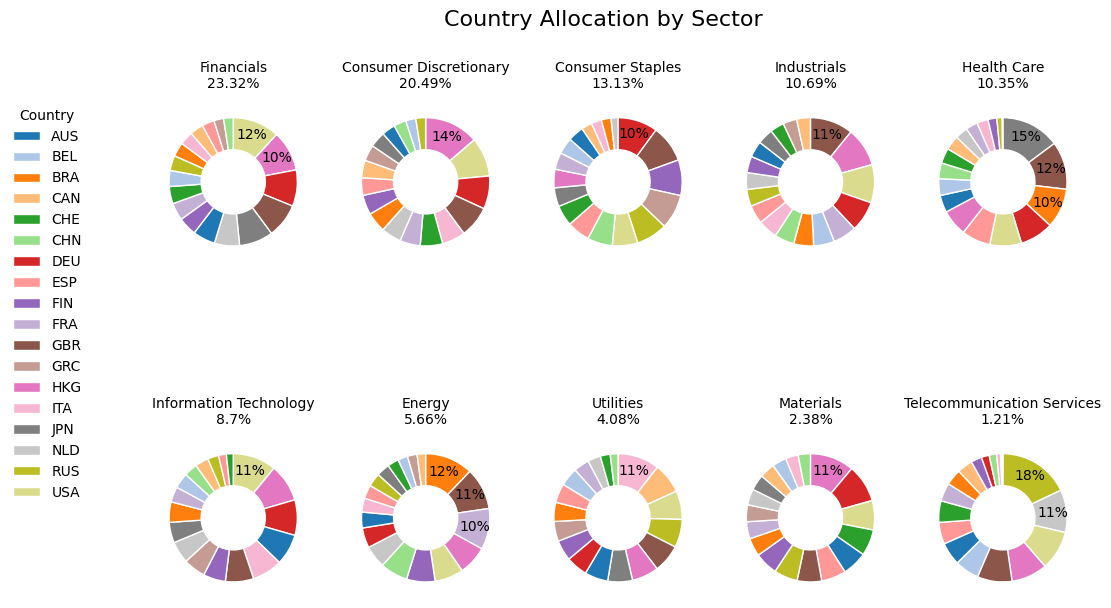

In [903]:
vhf.plot_country_allocation_by_sector(concise_positions)

At the industry-country level, we have 5 highly concentrated and large positions (using the criteria from above where the net exposure is larger than 0.50% of the total value of the portfolio and a bias greater than 50%). These are primarily in Health Care, Consumer Staples and Financials sector. In particular, our most concentrated exposure is a net short position in Japanese pharmaceuticals & biotechnology equities with a directional exposure of -$47.7m (tilt of -1.4%) 

In [904]:
df                      = concise_positions.groupby(['sector', 'country', 'industry'])[['gross_exposure_usd', 'net_exposure_usd']].sum()
gmv                     = concise_positions['gross_exposure_usd'].sum()

# Get the total value of all positions in that sector to calculate local_sector_tilt
df = df.reset_index().merge(
        sector_allocation.reset_index(),
        left_on='sector', right_on='sector',
        suffixes=('', '_sector_total')
        ).set_index(['sector', 'country']
    ).sort_index()


# Get how much is allocated to that local market as % of GMV
df['gmv_allocation_pct'] = df['gross_exposure_usd'] / gmv * 100
# Calculate tilt (% of portfolio gmv) of each local market
df['tilt'] = df['net_exposure_usd'] / gmv * 100
# Calculate local sector bias (per country per sector)
df['bias'] = df['net_exposure_usd'] / df['gross_exposure_usd'] * 100 

cond       = (df['tilt'].abs() > 0.5) & (df['gmv_allocation_pct'] > 0.5) & (df['bias'].abs() > 50)

concentrated_bets_country_industry= df[cond].copy()
concentrated_bets_country_industry[['gross_exposure_usd', 'net_exposure_usd',
       'gross_exposure_usd_sector_total']]  = (concentrated_bets_country_industry[['gross_exposure_usd', 'net_exposure_usd',
       'gross_exposure_usd_sector_total']] / 1e6)
print('\n Net Exposure and Gross Exposure are in $Mn')
concentrated_bets_country_industry = concentrated_bets_country_industry.sort_values(by='tilt', ascending=False, key = lambda x : x.abs()).round(2)
concentrated_bets_country_industry


 Net Exposure and Gross Exposure are in $Mn


industry  gross_exposure_usd  \
sector           country                                                        
Health Care      JPN      Pharmaceuticals & Biotechnology               50.51   
                 ESP      Pharmaceuticals & Biotechnology               24.38   
Consumer Staples FIN        Household & Personal Products               23.56   
Financials       JPN                                Banks               33.17   
Consumer Staples GBR        Household & Personal Products               16.99   

                          net_exposure_usd  gross_exposure_usd_sector_total  \
sector           country                                                      
Health Care      JPN                -47.72                           342.52   
                 ESP                 24.38                           342.52   
Consumer Staples FIN                 23.56                           434.65   
Financials       JPN                -19.60                           771.56   
Consumer Staples GBR                 16.99                           434.65   

                          sector_weight  gmv_allocation_pct  tilt    bias  
sector           country                                                   
Health Care      JPN              10.35                1.53 -1.44  -94.48  
                 ESP              10.35                0.74  0.74  100.00  
Consumer Staples FIN              13.13                0.71  0.71  100.00  
Financials       JPN              23.32                1.00 -0.59  -59.07  
Consumer Staples GBR              13.13                0.51  0.51  100.00

At the sub-industry level, using the same criteria as the above two sections, we also have 5 highly concentrated exposures. Of the 5 notable sub industry exposures, 4 of them are within the pharmaceuticals & biotechnology industry. There are 2 net short positions in the Japanese Pharmaceuticals and Biotechnology industry, that being the Life Sciences Tools & Services (LST) and Biotechnology sub industry respectively. JPN LST has a tilt of -0.74% ($-24.3m) and a bias of -100% thus being a pure short position. JPN Biotechnology has a -0.71% tilt (-$23.3m) and a short bias of -89%. 



In [905]:
df                      = concise_positions.groupby(['sector', 'country', 'industry', 'sub_industry'])[['gross_exposure_usd', 'net_exposure_usd']].sum()
gmv                     = concise_positions['gross_exposure_usd'].sum()

# Get the total value of all positions in that sector to calculate local_sector_tilt
df = df.reset_index().merge(
        sector_allocation.reset_index(),
        left_on='sector', right_on='sector',
        suffixes=('', '_sector_total')
        ).set_index(['sector', 'country']
    ).sort_index()


# Get how much is allocated to that local market as % of GMV
df['gmv_allocation_pct'] = df['gross_exposure_usd'] / gmv * 100
# Calculate tilt (% of portfolio gmv) of each local market
df['tilt'] = df['net_exposure_usd'] / gmv * 100
# Calculate local sector bias (per country per sector)
df['bias'] = df['net_exposure_usd'] / df['gross_exposure_usd'] * 100 

cond       = (df['tilt'].abs() > 0.5) & (df['gmv_allocation_pct'] > 0.5) & (df['bias'].abs() > 50)
print('\n Net Exposure and Gross Exposure are in $Mn')

concentrated_bets_country_industry= df[cond].copy()


concentrated_bets_country_industry = concentrated_bets_country_industry.sort_values(by='tilt', ascending=False, key = lambda x : x.abs()).round(2)
display(concentrated_bets_country_industry)


 Net Exposure and Gross Exposure are in $Mn


industry  \
sector           country                                    
Health Care      JPN      Pharmaceuticals & Biotechnology   
Consumer Staples FIN        Household & Personal Products   
Health Care      JPN      Pharmaceuticals & Biotechnology   
                 ESP      Pharmaceuticals & Biotechnology   
                 BRA      Pharmaceuticals & Biotechnology   

                                            sub_industry  gross_exposure_usd  \
sector           country                                                       
Health Care      JPN      Life Sciences Tools & Services         24375852.38   
Consumer Staples FIN                  Household Products         23561200.95   
Health Care      JPN                       Biotechnology         26134464.04   
                 ESP                       Biotechnology         21234285.49   
                 BRA      Life Sciences Tools & Services         18620322.09   

                          net_exposure_usd  gross_exposure_usd_sector_total  \
sector           country                                                      
Health Care      JPN          -24375852.38                     3.425232e+08   
Consumer Staples FIN           23561200.95                     4.346532e+08   
Health Care      JPN          -23347735.54                     3.425232e+08   
                 ESP           21234285.49                     3.425232e+08   
                 BRA          -18620322.09                     3.425232e+08   

                          sector_weight  gmv_allocation_pct  tilt    bias  
sector           country                                                   
Health Care      JPN              10.35                0.74 -0.74 -100.00  
Consumer Staples FIN              13.13                0.71  0.71  100.00  
Health Care      JPN              10.35                0.79 -0.71  -89.34  
                 ESP              10.35                0.64  0.64  100.00  
                 BRA              10.35                0.56 -0.56 -100.00

## Liquidity Risk

#### Liquidity of Portfolio

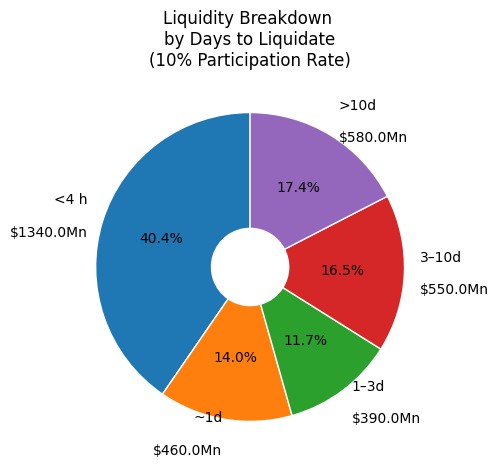

In [906]:

concise_positions = vhf.days_to_liquidate(concise_positions, 0.10)
concise_positions = vhf.bucket_by_liquidity(concise_positions, 0.10)
liq_breakdown_port = vhf.plot_overall_liquidity_profile(concise_positions, 0.10)

#### Liquidity by Sector

/Users/phillip/Desktop/Moon2/Voleon_WorkSample/Voleon_WorkSample_helper_funcs.py:815: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dtl_bucket_breakdown = concise_positions.pivot_table(


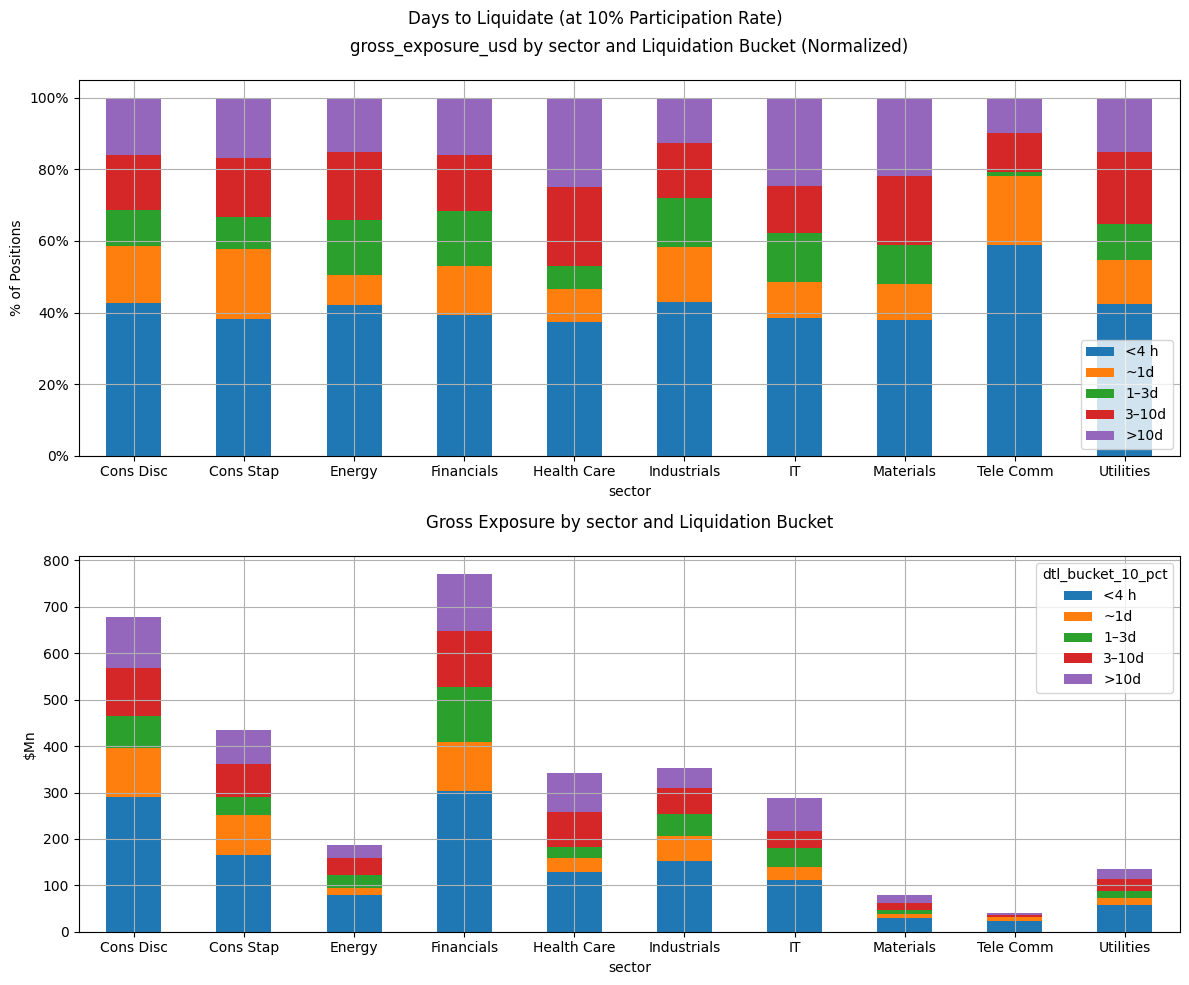

In [907]:

sector_liqbucket = vhf.plot_by_liq_bucket(concise_positions, 'sector')

#### Liquidity by Industry 

/Users/phillip/Desktop/Moon2/Voleon_WorkSample/Voleon_WorkSample_helper_funcs.py:815: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dtl_bucket_breakdown = concise_positions.pivot_table(


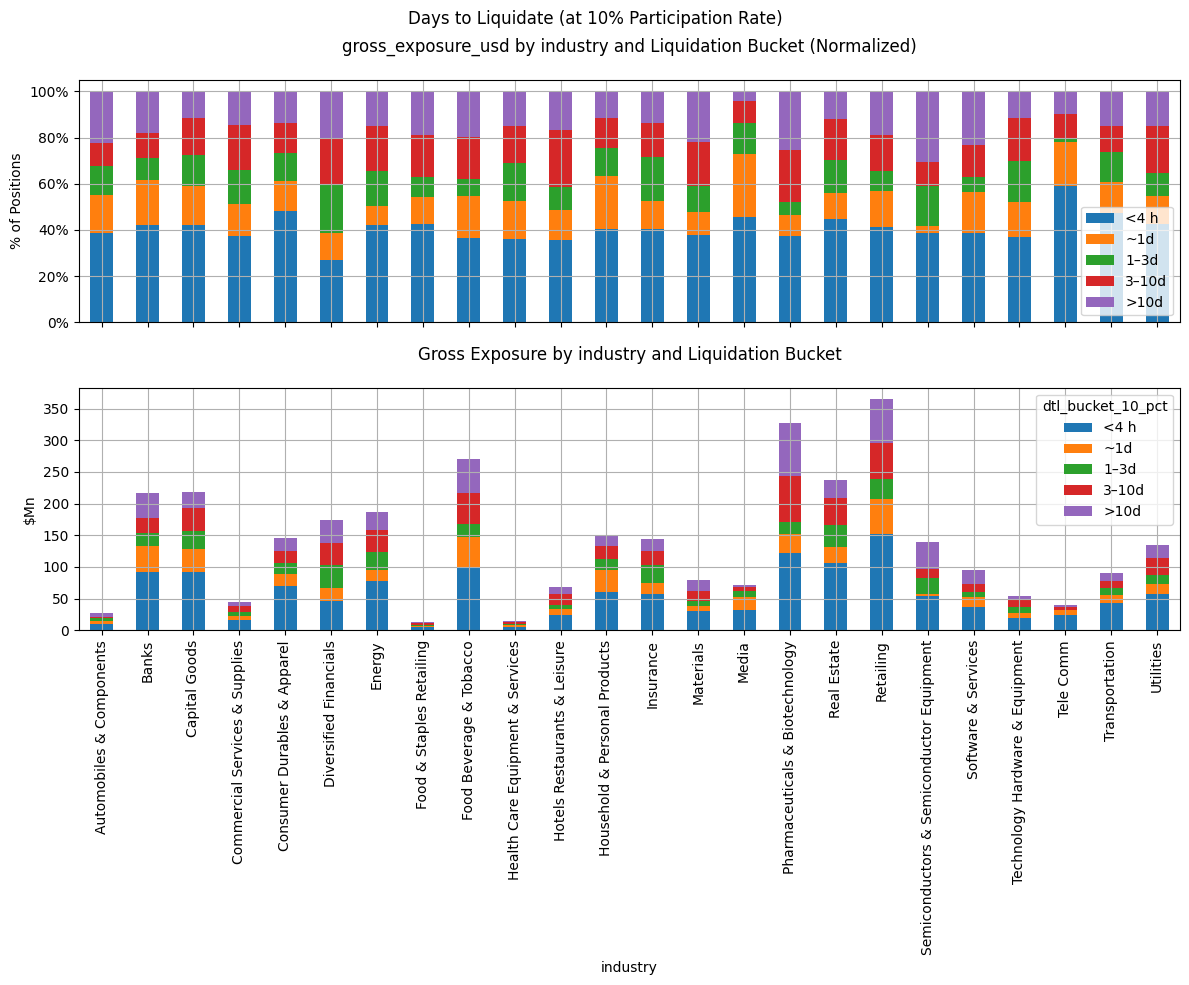

In [908]:
industry_liqbucket = vhf.plot_by_liq_bucket(concise_positions, col = 'industry', sharex = True)


#### Liquidity By Country 

/Users/phillip/Desktop/Moon2/Voleon_WorkSample/Voleon_WorkSample_helper_funcs.py:815: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dtl_bucket_breakdown = concise_positions.pivot_table(


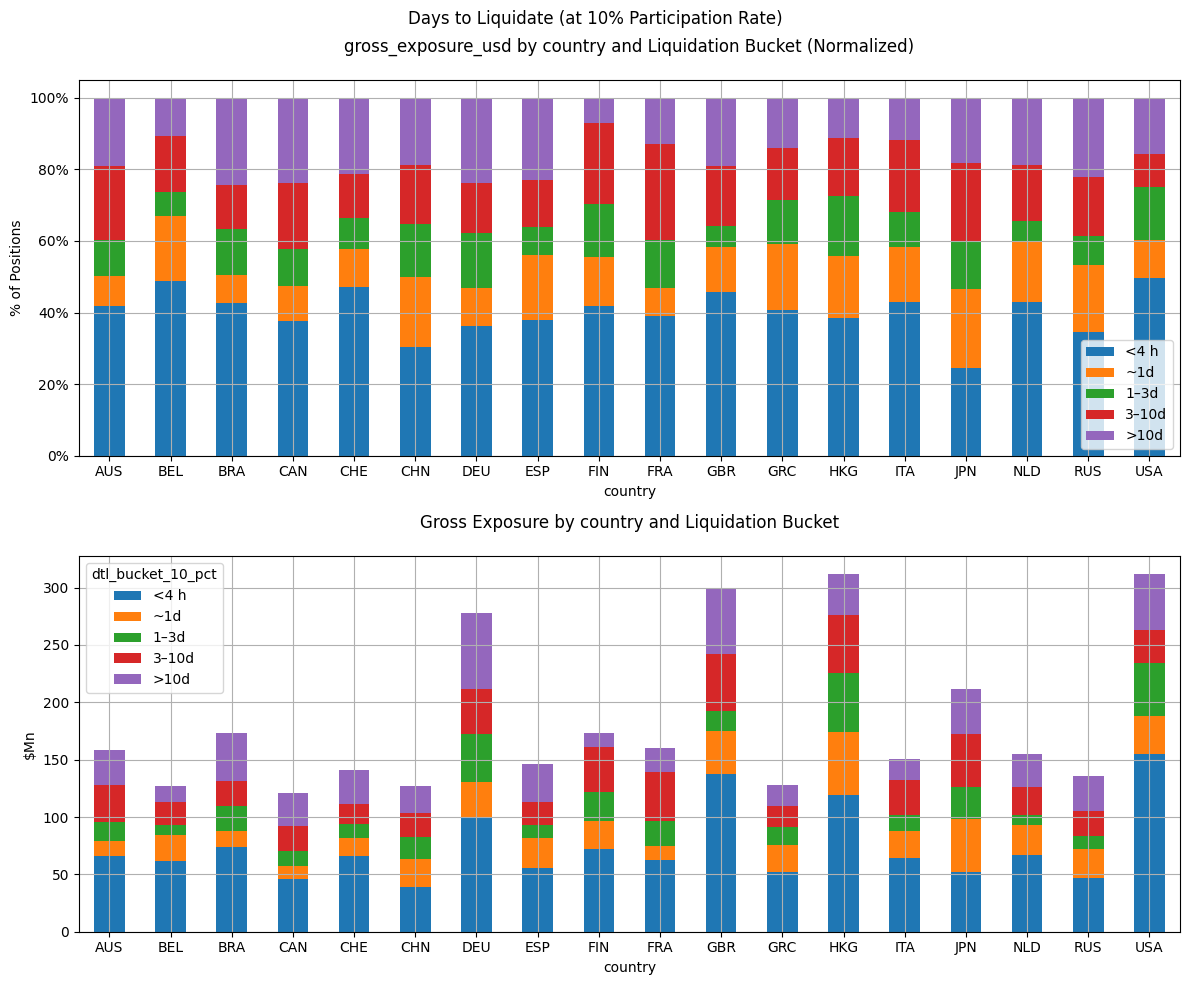

In [909]:
country_by_liqbucket = vhf.plot_by_liq_bucket(concise_positions, 'country')

#### Liquidity by Currency

/Users/phillip/Desktop/Moon2/Voleon_WorkSample/Voleon_WorkSample_helper_funcs.py:815: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dtl_bucket_breakdown = concise_positions.pivot_table(


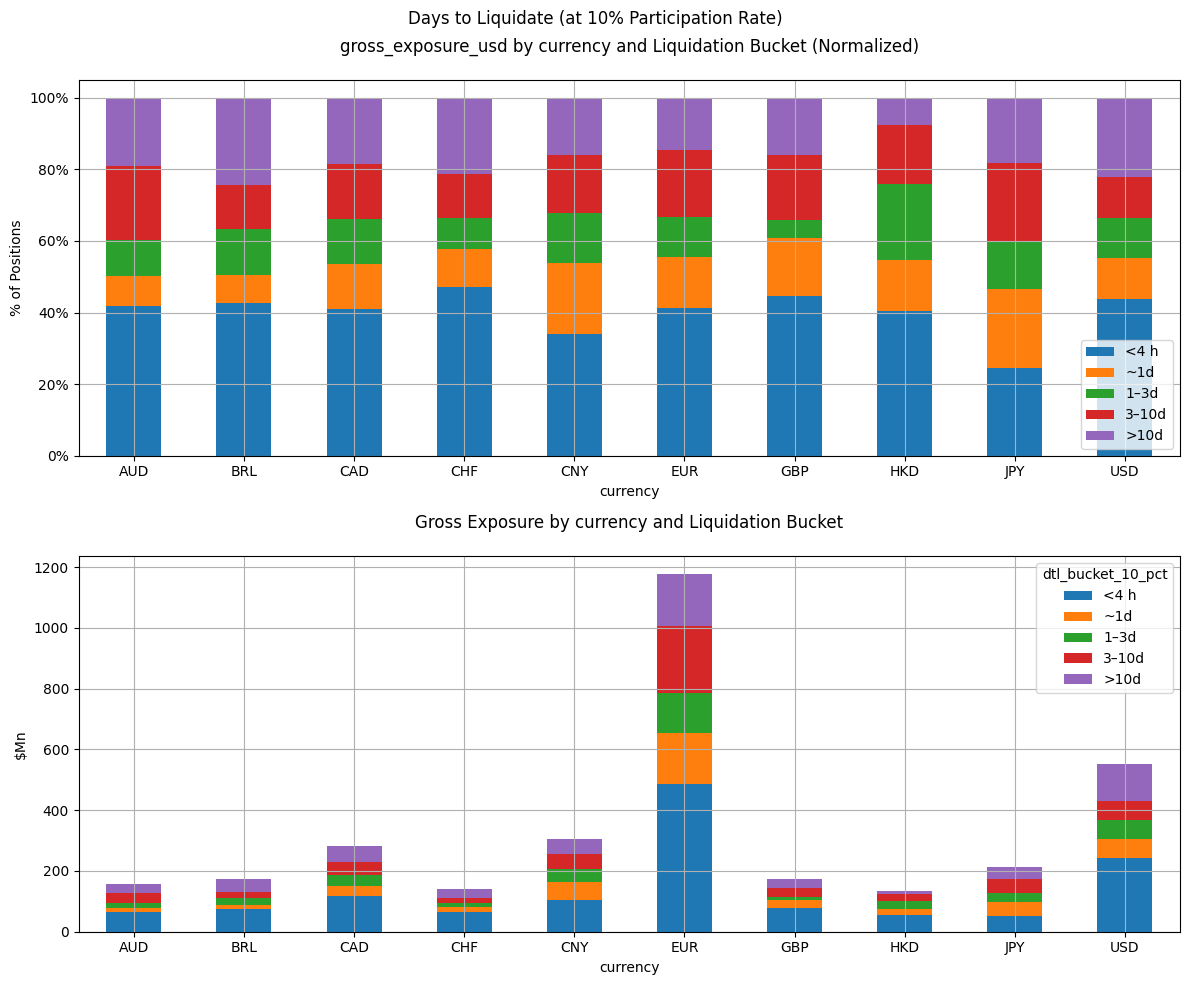

In [910]:
currency_by_liqbucket = vhf.plot_by_liq_bucket(concise_positions, 'currency')

## Positions to Monitor

#### Position to Monitor : FIN Longs in Regional Banks and Househould Product Equities

FIN has a very long exposure but concentrated in only 4 tickers

In [911]:
concise_positions[(concise_positions['country'] == 'FIN')].groupby('sector')[['net_exposure_usd', 'gross_exposure_usd']].sum().sort_values(by='net_exposure_usd', ascending=False) / 1e6

,net_exposure_usd,gross_exposure_usd
sector,,
Consumer Staples,35.593431,39.034048
Financials,27.383487,36.185185
Utilities,6.468428,7.013572
Telecommunication Services,1.101636,1.101636
Materials,0.403720,4.566505
Information Technology,-2.100646,16.195057
Industrials,-4.946842,14.617387
Health Care,-6.838937,7.643988
Consumer Discretionary,-7.877563,33.604399


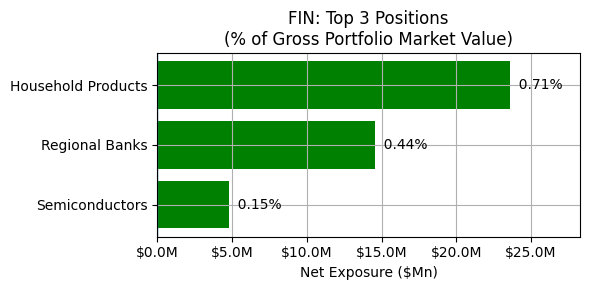

In [912]:
df = (concise_positions.groupby('country').get_group('FIN').groupby(['sub_industry'])[['net_exposure_usd', 'gross_exposure_usd']].sum().sort_values(by='net_exposure_usd', ascending=False))
df['net_tilt_pct'] = df['net_exposure_usd'] / concise_positions['gross_exposure_usd'].sum() * 100
vhf.plot_top_longs(df.head(3),title='FIN: Top 3 Positions\n(% of Gross Portfolio Market Value)')
plt.show();

In [913]:
concise_positions.groupby(['country','sub_industry']).get_group(('FIN', 'Household Products',))

,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,...,unrealized_pnl_usd,net_exposure_usd,gross_exposure_usd,beta_weighted_exposure_usd,gross_beta_weighted_exposure_usd,portfolio_weight,position_pct_of_adv,days_to_liquidate_10_pct,dtl_bucket_10_pct,gross_beta_exposure_usd
stock_id,,,,,,,,,,,,,,,,,,,,,
250,GET,FIN,EUR,Consumer Staples,Household & Personal Products,Household Products,1.881098,156476,LONG,87980,...,-3.098924e+05,9.415661e+06,9.415661e+06,1.771178e+07,1.771178e+07,0.002845,56.225875,5.62,3–10d,1.771178e+07
1186,TNX,FIN,EUR,Consumer Staples,Household & Personal Products,Household Products,0.878405,385235496,LONG,79753,...,1.093623e+06,1.414554e+07,1.414554e+07,1.242551e+07,1.242551e+07,0.004275,0.020702,0.00,<4 h,1.242551e+07


In [914]:
Finland = concise_positions[concise_positions['country'] == 'FIN'].copy()
Finland.groupby(['industry', 'sub_industry'])[['net_exposure_usd', 'gross_exposure_usd']].sum().sort_values(by='net_exposure_usd', ascending=False).loc['Banks']

,net_exposure_usd,gross_exposure_usd
sub_industry,,
Regional Banks,1.457018e+07,1.457018e+07
Thrifts & Mortgage Finance,1.909750e+05,1.909750e+05


#### Position to Monitor : Long BRA Pharmaceuticals Concentration

<Axes: xlabel='country,sub_industry'>

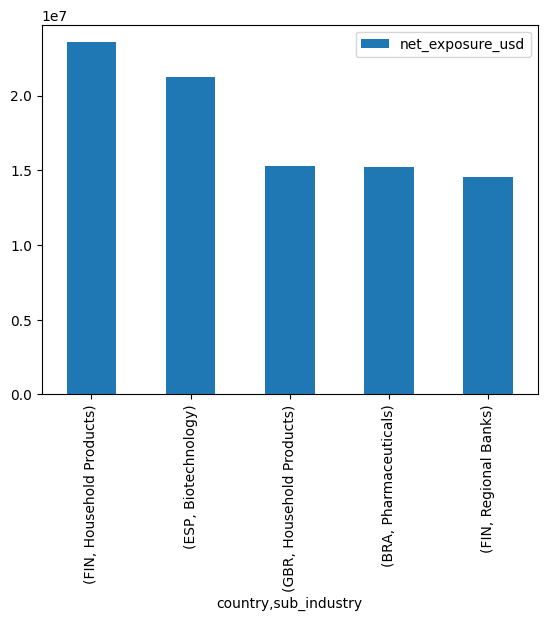

In [915]:
concise_positions.groupby(['country','sub_industry'])[['net_exposure_usd']].sum().sort_values(by='net_exposure_usd', ascending=False)[:5].plot.bar()

In [916]:
concise_positions[(concise_positions['sub_industry'] == 'Pharmaceuticals') & (concise_positions['country'] == 'BRA')]

,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,...,unrealized_pnl_usd,net_exposure_usd,gross_exposure_usd,beta_weighted_exposure_usd,gross_beta_weighted_exposure_usd,portfolio_weight,position_pct_of_adv,days_to_liquidate_10_pct,dtl_bucket_10_pct,gross_beta_exposure_usd
stock_id,,,,,,,,,,,,,,,,,,,,,
676,NFC,BRA,BRL,Health Care,Pharmaceuticals & Biotechnology,Pharmaceuticals,2.246111,11786,LONG,29835,...,-157820.176875,2.243937e+06,2.243937e+06,5.040133e+06,5.040133e+06,0.000678,253.139318,25.31,>10d,5.040133e+06
2930,DFB,BRA,BRL,Health Care,Pharmaceuticals & Biotechnology,Pharmaceuticals,3.108001,56968,LONG,111590,...,768118.581563,1.296757e+07,1.296757e+07,4.030321e+07,4.030321e+07,0.003919,195.881899,19.59,>10d,4.030321e+07


#### Positions to Monitor : Health Care Shorts Position + JPN LSTS

- Net short in Health Care is the largest position in the portfolio
- Total of $199m short positions is partially hedged by $144m of long positions leaving a net short exposure of -1.65% of the gross market value of the portfolio
- Position is primarily driven by an net short $82m position in the Life Sciences Tools & Services (LSTS) sub industry

Position concentration:
- The top 4 short LSTS short positions come from JPN, BRA, BEL, and HKG
- These positions make up $68m (68%) of the entire global LSTS position 
- There is no long position in any of the top 4 countries


Liquidity of Asian LSTS shorts:
- JPN and HKG LSTS shorts (contributing -$24m and -$12m respectively) are extremely illiquid:
- Assumming 10% participation rate of Average Daily Volume
    - JPN : $12.7m and $11.6m in positions with DTL > 10 days and 3-10 days respectively 
    - HKG : $7.1m and $4.9m in positions > 10 days and 1-3 days respectively
- Illiquid positions in HKG and JPN make up ~42% of the portfolio's global LSTS position

Illiquidity of LSTS hedge @ 10% ADV:
- Within Health Care sector, only LSTS, Pharmaceuticals & Biotechnology have gross exposures over $3m
- LSTS, Pharmaceuticals and Biotechnology respectively have positions totalling $100m, $97m and $130m
- LSTS short is partially hedged with a $28m net long position in Pharmaceuticals while Biotechnology is essientally flat 

JPN:
- In particular, the JPN LSTS position has a highly concentrated exposure to not only the JPN LSTS market but also the JPN market
- JPN LSTS position is short the Japanese market risk premia; contributing -$26.8m to the -$46.1m beta-weighted net exposure to JPN
- JPN also has a significant short JPN market beta position in the Biotechnology sub industry of $19.1m
- The combination of illiquity and concentration in both the LSTS and Biotechnology sub industries should make JPN health care positions a priority to monitor
- In the event of JPN market rally, or upside move in the LSTS or Biotechnology sub industries could result in difficulty covering shorts 


In [917]:
def sum_mil(x):
    return (x.sum() / 1e6).round(2)

In [918]:
# Largest position by country/sector/industry/sub-industry
df = concise_positions.pivot_table(index='country', columns=['sector','industry', 'sub_industry'], values='net_exposure_usd', aggfunc=sum_mil, margins=True).fillna(0)
HC = df['Health Care'].copy()
# Make the numbers easier to see
display(HC['Pharmaceuticals & Biotechnology'].sort_values(by='Life Sciences Tools & Services', ascending=True).head().replace(0.0, '-'))

sub_industry,Biotechnology,Life Sciences Tools & Services,Pharmaceuticals
country,,,
All,0.9,-82.14,27.99
JPN,-23.35,-24.38,-
BRA,-,-18.62,15.21
BEL,-,-13.53,-
HKG,-,-12.03,-0.66


In [919]:
concise_positions.groupby(['side', 'country','sub_industry'])[['net_exposure_usd']].sum().sort_values(by='net_exposure_usd', ascending=True).loc[(slice(None), slice(None), 'Biotechnology'), :]

net_exposure_usd
side  country sub_industry                   
SHORT JPN     Biotechnology     -2.474110e+07
      USA     Biotechnology     -1.164682e+07
      NLD     Biotechnology     -1.059765e+07
      GBR     Biotechnology     -8.781991e+06
      CHE     Biotechnology     -5.627251e+06
      FIN     Biotechnology     -3.051662e+06
LONG  CHN     Biotechnology      7.194766e+05
      JPN     Biotechnology      1.393364e+06
      USA     Biotechnology      5.218104e+06
      CAN     Biotechnology      8.343604e+06
      DEU     Biotechnology      8.803947e+06
      GBR     Biotechnology      1.963783e+07
      ESP     Biotechnology      2.123429e+07

In [920]:
concise_positions.groupby(['sub_industry'])[['net_exposure_usd', 'gross_exposure_usd']].sum().sort_values(by='net_exposure_usd', ascending=False).loc['Biotechnology'] / 1e6

net_exposure_usd        0.904141
gross_exposure_usd    129.797079
Name: Biotechnology, dtype: float64

In [921]:
# looking at JPN pharmaceutical and biotech positions specifically
JPN = concise_positions[(concise_positions['industry'] == 'Pharmaceuticals & Biotechnology') & (concise_positions['country'] == 'JPN')].copy()
JPN = JPN.sort_values(by='net_exposure_usd', ascending=True)
beta_gmv = concise_positions['beta_weighted_exposure_usd'].abs().sum()

# Japan positions are very concentrated short
JPN[['ticker', 'net_exposure_usd']]

,ticker,net_exposure_usd
stock_id,,
2970,ZXT,-1.964231e+07
1420,FUA,-1.163325e+07
329,XMX,-1.095966e+07
565,IZA,-5.098791e+06
816,LTQ,-1.782941e+06
2543,DIY,1.393364e+06


#### Positions to not Monitor : Flat Emerging Markets / Developed Markets Positions 

The emerging market positions are largely market-neutral, with a flat net long market beta position of 0.2% of the portfolio's gross beta-weighted exposure. The portfolio's net short market risk premia position comes from a -3% short beta tilt in developed markets, suggesting potential downside risks if developed markets rally.

In dollar terms, EM shows a net short exposure similar to Developed but off much smaller gross. EM is net short -$33m while Developed is net short -$36m, despite Developed having almost a 5x gross exposure compared to EM. Both are have small net shorts, but EM's risk profile is more one-sided, and sensitive to non-market beta and idiosyncratic drivers rather than broad market moves.

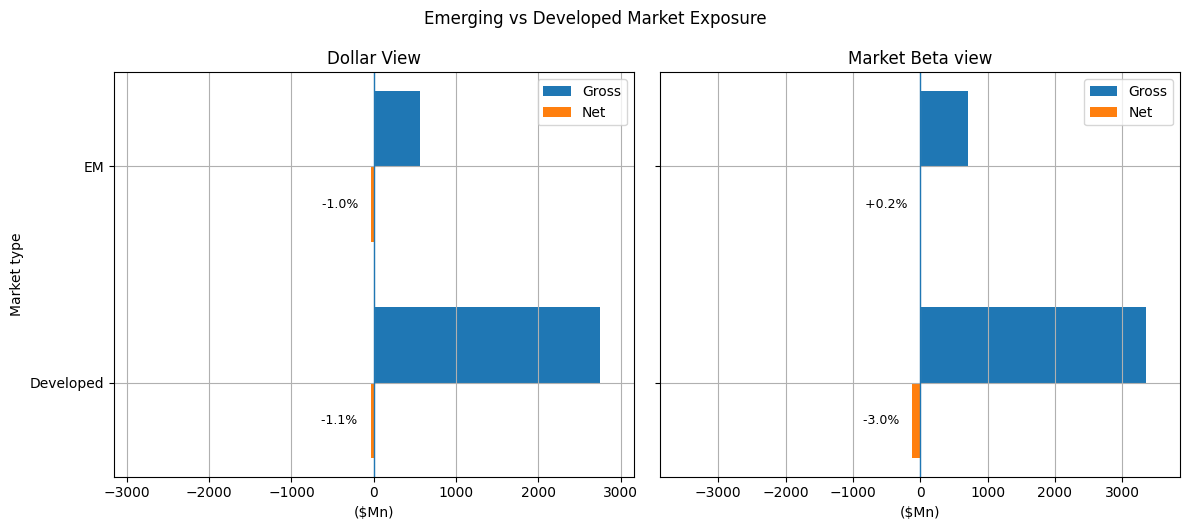

In [922]:

market_type_exposure, beta_weighted_mkt_exposure = vhf.calc_emerging_market_exposure(concise_positions)
vhf.plot_dev_em_dollar_vs_beta(market_type_exposure, beta_weighted_mkt_exposure)
plt.suptitle('Emerging vs Developed Market Exposure', y=1.05)
plt.show()


#### Positions to Monitor : Long USD / Short JPY (Carry Trade)

**Long USD/Japan Carry trade exposures:**

The biggest country-sector shorts are Japan Health Care and Japan Financials, alongside a short JPY (long USD) FX position.
This setup benefits if the yen stays weak and the U.S.–Japan rate gap widens (BoJ stays dovish / JGB yields capped)
- Short Japanese Financials (rates-sensitive) : -0.6% ($-19m)
- Short Japanese Health Care : -1.4% (-$47.5m)
- Short Yen : -2% (-$65.2m)
- Long USD : 1.5% ($50.7)

**Key risk**:
- BoJ Monetary policy : hawkish shift or a risk-off rally in the yen
- Japanese yield curve : steepening curve could also lift Japanese banks and work against the Financials short
- Dollar weakness : stalling US growth expectations could result in dovish policy reducing carry and hurting long USD positions

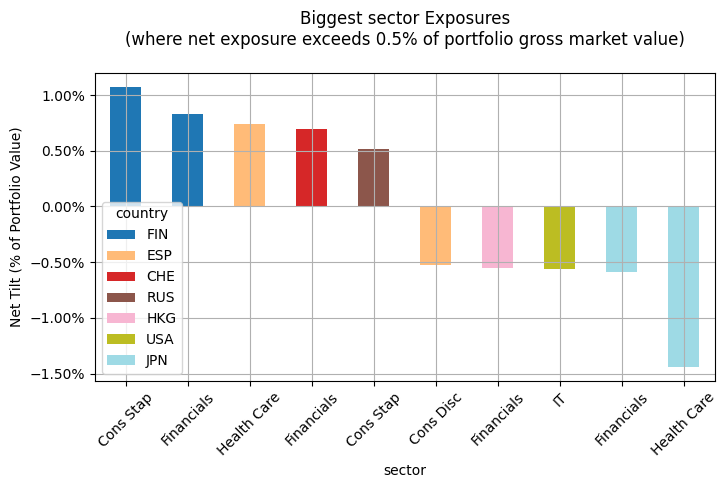

In [923]:

df, ax = vhf.plot_biggest_tilts(concise_positions, col = 'sector', thresh=0.5, ref_col='country', figsize = (8,4))
plt.xticks(rotation = 45)
plt.show();

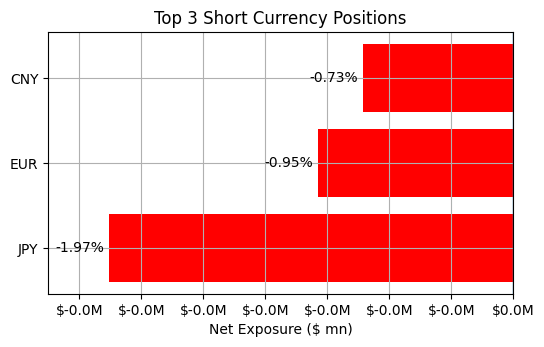

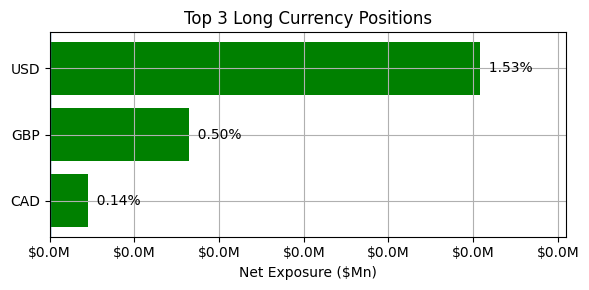

In [924]:
curr_pos = vhf.calc_currency_positions(concise_positions)
ax = vhf.plot_top_shorts(curr_pos.tail(3), 'net_exposure_usd', 'net_tilt_pct', title='Top 3 Short Currency Positions')
ax2 = vhf.plot_top_longs(curr_pos.head(3), 'net_exposure_usd', 'net_tilt_pct', title='Top 3 Long Currency Positions')

## PnL Analysis

Not much has changed at the portfolio level from when we entered into our position vs where we are now
- Need FX entry rates to break down pnl attribution by FX + Sector/Market moves etc
- Need benchmark to measure alpha
- Profit of $29m so far 


In [925]:
def build_cost_basis_df(positions):
    """ 
    Build a dataframe showing cost basis and exposures in USD
        """
    df = positions.copy()
    df['cost_basis_usd']          = df['cost_basis_local'] * df['currency_conversion']
    df['net_exposure_cost_usd']   = df['cost_basis_usd'] * df['posn_shares']
    df['gross_exposure_cost_usd'] = df['net_exposure_cost_usd'].abs()

    df['beta_weighted_exposure_cost_usd']       = df['cost_basis_usd'] * df['posn_shares'] * df['beta']
    df['gross_beta_weighted_exposure_cost_usd'] = df['beta_weighted_exposure_cost_usd'].abs()

    cols_drop = ['gross_exposure_usd', 'net_exposure_usd', 'gross_beta_weighted_exposure_usd', 'beta_weighted_exposure_usd']

    df_costbasis = df.drop(columns=cols_drop).copy()

    return df_costbasis

def rename_columns_cost_basis(df):
    """ 
    Rename columns to indicate cost basis exposures
        """
    df = df.rename(columns={
        'net_exposure_cost_usd': 'net_exposure_usd',
        'gross_exposure_cost_usd': 'gross_exposure_usd',
        'beta_weighted_exposure_cost_usd': 'beta_weighted_exposure_usd',
        'gross_beta_weighted_exposure_cost_usd': 'gross_beta_weighted_exposure_usd'
    })
    return df


In [955]:
df_costbasis = build_cost_basis_df(positions)
df_costbasis = rename_columns_cost_basis(df_costbasis)
df_costbasis_summary = vhf.build_overall_exposure_summary(df_costbasis)

overall_summary = vhf.build_overall_exposure_summary(concise_positions)
summary_change = pd.concat([df_costbasis_summary, overall_summary], axis=1, keys=['Entry', 'Current'])
summary_change = summary_change.droplevel(1, axis=1)
summary_change.round(2)

,Entry,Current
Net Exposure ($Mn),-99.37,-69.78
Gross Market Value ($Mn),3306.47,3309.23
Net Beta-Weighted Exposure ($Mn),-149.01,-112.55
Gross Beta-Weighted Exposure ($Mn),4065.93,4066.77
(Value-Weighted) Avg Days to Liquidate,4.96,4.98
Longs Market Value ($Mn),1603.55,1619.73
Shorts Market Value ($Mn),1702.92,1689.50
Net Exposure Ratio (%),-3.01,-2.11
Beta Tilt (%),-3.66,-2.77
Portfolio Beta,-0.05,-0.03


### PnL

In [927]:
profit = (concise_positions[['unrealized_pnl_usd']].sum() / 1e6)
returns = profit / (df_costbasis['gross_exposure_usd'].sum() / 1e6) * 100

print(f'Unrealized PnL : ${profit.values[0]:.2f} Mn')
print(f'Returns since entry (based on cost basis gross exposure) : {returns.values[0]:.2f} %')

Unrealized PnL : $29.59 Mn
Returns since entry (based on cost basis gross exposure) : 0.90 %


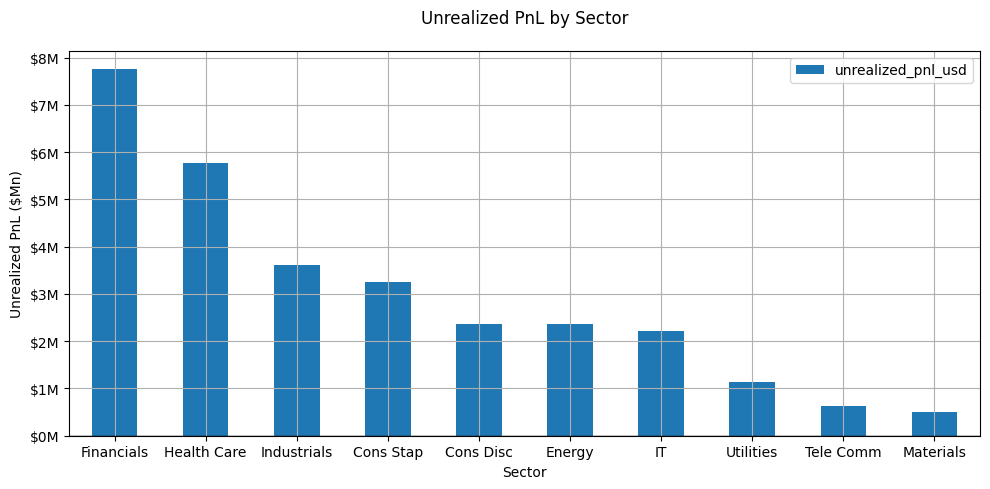

In [977]:
def plot_pnl_by_group(concise_positions, group, figsize=(10,5)):
    """ 
    Plot unrealized PnL by group (sector, industry, country etc..)
    """
    from matplotlib.ticker import FuncFormatter
    pnl_by_group = (concise_positions
                    .groupby(group)[['unrealized_pnl_usd']]
                    .sum()
                    .sort_values(by='unrealized_pnl_usd', ascending=False)
                   ) / 1e6

    ax = pnl_by_group.plot.bar(
        figsize=figsize,
    )
    ax.axhline(0, color='k', lw=1)
    ax.set_xlabel(group.capitalize())
    ax.set_ylabel('Unrealized PnL ($Mn)')
    ax.set_title(f'Unrealized PnL by {group.capitalize()}', pad=20)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'${x:,.0f}M'))
    ax.set_xticklabels(shorten_labels(pnl_by_group.index), rotation=0)
    ax.grid()
    plt.tight_layout()

    return pnl_by_group

def plot_pnl_top_bottom(df, *by, value='unrealized_pnl_usd', n=3, title=None, figsize=(10,5)):
    """
    Example:
      plot_pnl_top_bottom(concise_positions, 'sector', 'country', value='unrealized_pnl_usd', n=3)
    """
    from matplotlib.ticker import FuncFormatter
    s = df.groupby(list(by), dropna=False)[value].sum().sort_values()
    pos = s[s > 0].nlargest(n)
    neg = s[s < 0].nsmallest(n)

    fmt = FuncFormatter(lambda x, _:
                        f"-${abs(x):,.1f}M" if x < 0 else f"${x:,.1f}M")

    def _labels(idx):
        return ['\n'.join(map(str, i)) if isinstance(i, tuple) else str(i) for i in idx]

    fig, axes = plt.subplots(1, 2, sharex=False, figsize=figsize)
    for ax, data, hdr in [(axes[0], pos/1e6, f"Top {len(pos)}"),
                          (axes[1], neg/1e6, f"Bottom {len(neg)}")]:
        bars = ax.bar(_labels(data.index), data.values,color=['tab:green' if x > 0 else 'tab:red' for x in data.values])
        ax.axvline(0, lw=1)
        ax.set_title(hdr)
        ax.xaxis.set_tick_params(rotation=90)
        ax.yaxis.set_major_formatter(fmt)
        ax.grid()
        labels = [f"-${abs(v):,.2f}M" if v < 0 else f"${v:,.2f}M" for v in data.values]
        ax.bar_label(bars, labels=labels, padding=5)  

    if title: fig.suptitle(title)
    return fig, axes

pnl_by_sector = plot_pnl_by_group(concise_positions, 'sector')


In [978]:
pnl_by_sector

,unrealized_pnl_usd
sector,
Financials,7.757475
Health Care,5.776578
Industrials,3.612989
Consumer Staples,3.243600
Consumer Discretionary,2.368734
Energy,2.359456
Information Technology,2.217443
Utilities,1.133743
Telecommunication Services,0.623252


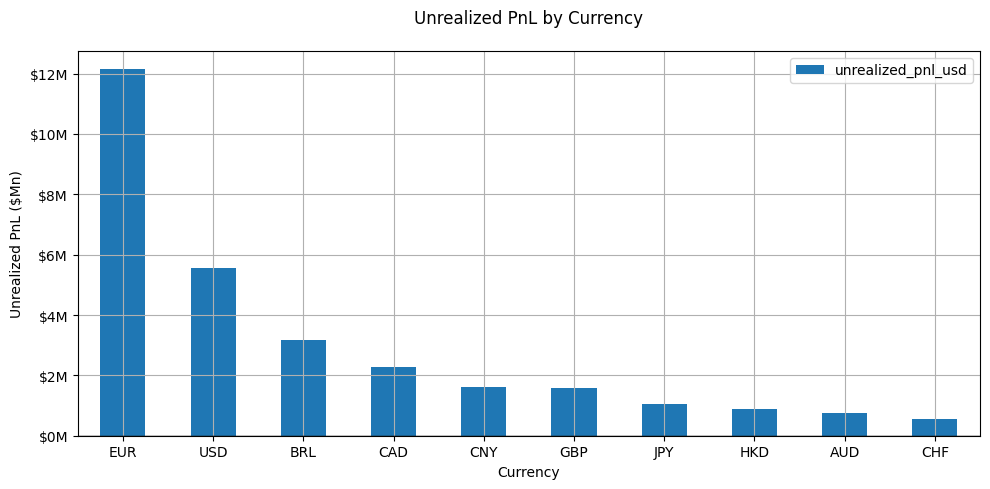

In [979]:
pnl_by_curr = plot_pnl_by_group(concise_positions, 'currency')

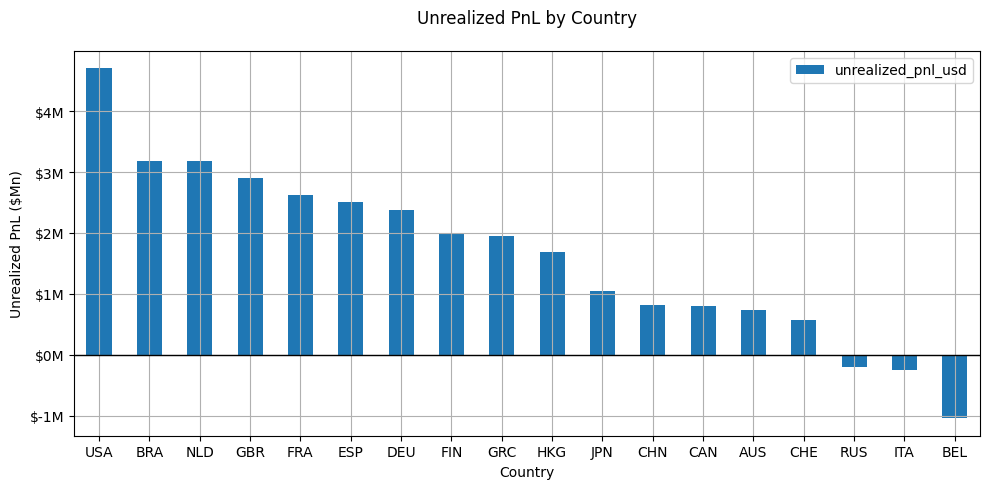

In [982]:
pnl_by_country = plot_pnl_by_group(concise_positions, 'country')

In [983]:
pnl_by_country

,unrealized_pnl_usd
country,
USA,4.702003
BRA,3.182502
NLD,3.174082
GBR,2.900226
FRA,2.615578
ESP,2.509644
DEU,2.384163
FIN,1.996949
GRC,1.946377


(<Figure size 1600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Top 5'}>,
        <Axes: title={'center': 'Bottom 5'}>], dtype=object))

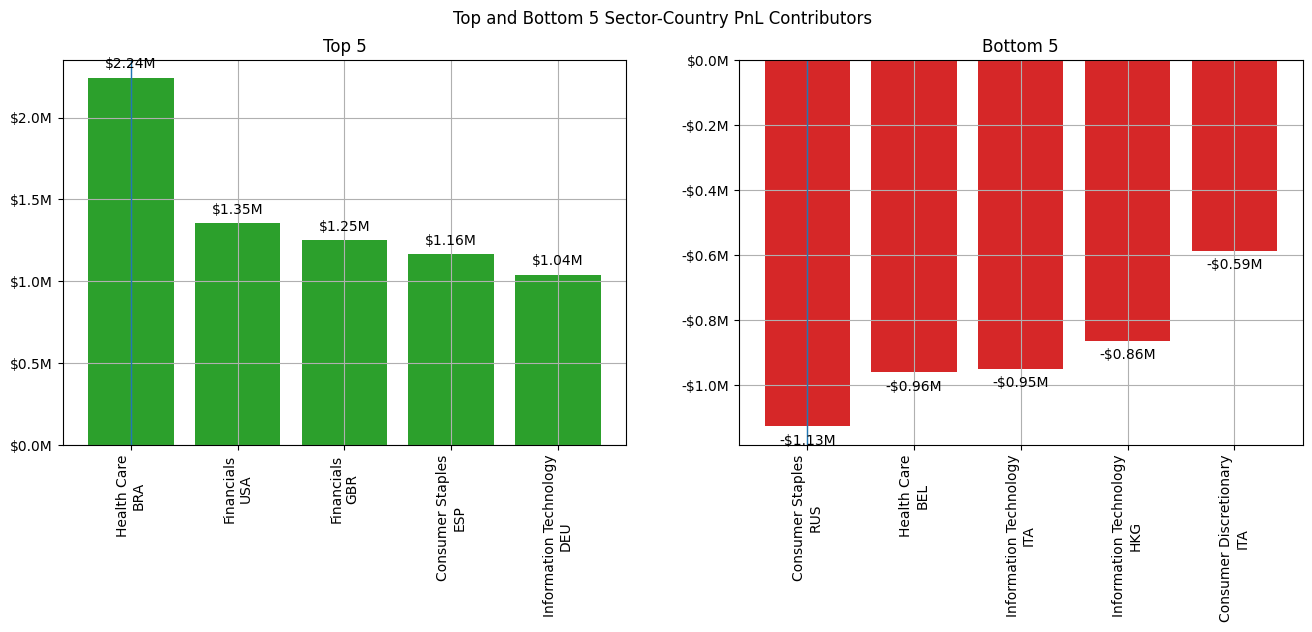

In [981]:
plot_pnl_top_bottom(concise_positions, 'sector', 'country', value='unrealized_pnl_usd', n=5, title='Top and Bottom 5 Sector-Country PnL Contributors', figsize= (16, 5))

### Scenario Analysis

In [961]:
# Up Move Scenario: 1% increase in all markets
print((0.01 * concise_positions['beta'] * concise_positions['net_exposure_usd']).sum() / 1e6)
# Down Move Scenario: 1% decrease in all markets
print((-0.01 * concise_positions['beta'] * concise_positions['net_exposure_usd']).sum() / 1e6)#

-1.1254505855130088
1.1254505855130088


In [939]:
# +1 % FX move in USD against all other currencies
fx_impact_up = concise_positions.apply(
    lambda row:
        0.01 * row['net_exposure_usd'] if row['currency'] != 'USD' else 0,
    axis=1
).sum() / 1e6

fx_impact_up

np.float64(-1.2052980628142416)

In [941]:
# -1 % FX move in USD against all other currencies
fx_impact_down = concise_positions.apply(
    lambda row:
        -0.01 * row['net_exposure_usd'] if row['currency'] != 'USD' else 0,
    axis=1
).sum() / 1e6

fx_impact_down

np.float64(1.2052980628142416)

In [959]:
# Top 3 Sector moves

impact_sector = {}
for i in concise_positions['sector'].unique():

    sector_pct_moves = 0.01 * concise_positions[concise_positions['sector'] == i]['net_exposure_usd'].sum() / 1e6
    # print(f'Sector: {i} | 1% Move Impact: ${sector_pct_moves:.2f} Mn')

    impact_sector[i] = sector_pct_moves

df = pd.DataFrame(impact_sector.values(), index=impact_sector.keys(), columns=['1% Move Impact ($Mn)'])
df.sort_values(by='1% Move Impact ($Mn)', key=lambda x : x.abs(), ascending=False).head(3)

,1% Move Impact ($Mn)
Health Care,-0.546465
Energy,-0.209359
Consumer Discretionary,-0.182091
